In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.stats import *
from cmath import phase
from numpy import array
from scipy.sparse import csr_matrix
import urllib
import glob
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from pymicro.view.vol_utils import compute_affine_transform
from sklearn import metrics
from random import randint
import math
import pickle

#!wget https://github.com/MelanieTschiersch/SmithData/blob/main/Sa191226.mat?raw=true # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat

#!wget https://github.com/comptelab/distributedWM/blob/main/smith/PFC_PFC/Sa191202.mat # , Pe180728.mat, Wa180222.mat
#!mv Sa191226.mat?raw=true Sa191226.mat #, Pe180728.mat, Sa191226.mat
#data={'Sa': [], 'Pe':[], 'Wa':[]}
#for m in ["Sa", "Pe", "Wa"]:
#    files = np.sort(glob.glob('../Data/%s*.mat' %m))#
#    for f in files:
##data = loadmat('distributedWM/smith/PFC_PFC/Sa191202.mat')#Sa191203
#        data[m].append(loadmat(f))
#        print(f)
    #files_web = np.sort(glob.glob('%s*.mat' %m))
    #for f in files_web:
    #    data[m].append(loadmat(f))#, Pe180728.mat, Wa180222.mat, Sa191226.mat

with open('../Data/new/df.pickle', 'rb') as handle:
    df_dat = pickle.load(handle)
    
with open('../Data/new/leftRightIdx.pickle', 'rb') as handle:
    leftRightIdx = pickle.load(handle)

In [2]:
# circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return nan
    
def circdist(angles1,angles2):
    ''' calculates circular distance of angles [rad]'''
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [3]:
def convert_cm2deg(x, y):
    '''
    Converts angles of visual degree to angles on WM circle

    Parameters
    ----------
    x : list of array of x-positions in deg for all sessions 
    y : list of array of y-positions in deg for all sessions

    Returns
    -------
    alpha_full: list of arrays of Angle on working-memory circle in [°] 

    '''

    alpha_full = np.zeros(len(x))
       
    # tangens only goes from 0-180, change to 0-360
    idx = np.where(np.logical_and(x>0, y>0))# for x,y>0
    alpha_full[idx] = [(3*np.pi)/2+np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]
    #print(np.array(alpha_full[idx])*180/np.pi)

    idx = np.where(np.logical_or(np.logical_and(x<0, y>0), np.logical_and(x<0, y<0)))# for x,y>0
    alpha_full[idx] = [np.pi-np.pi/2+np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]
    
    idx = np.where(np.logical_and(x>0, y<0))
    alpha_full[idx] = [2*np.pi-np.pi/2+np.arctan((y[k]*np.pi/180)/(x[k]*np.pi/180)) for k in idx]
    return [i*180/np.pi for i in alpha_full]

In [4]:
def calc_errorcurve(results):
    '''
    Calculates single-sided serial dependence curve

    Parameters
    ----------
    results :   monkey data for [subject][params], with params:
                            target1:   target shown in previous trial
                            target2:   target shown in current trial
                            response1: response given in previous trial
                            response2: response given in current trial
                results : {"a": {"target1": [],"target2": [],"response1": [],"response2": []}, 
                           "l": {"target1": [],"target2": [],"response1": [],"response2": []}}
                w1      : smoothing window width
                w2      : smoothing window shift

    Returns
    -------
    err_avg : average smoothed error per monkey 
    rel_loc_avg : relative location equally spaced in [0,pi]
    err_std : sem of smoothed error
    err : original (unsmoothed) flipped error to (0,pi)

    '''
    rel_loc=[]
    err = []
    rel_loc.append(circdist(results['target_curr'],results['target_prev']))# relative location current prvious stimulus
    err.append(circdist(results['target_curr'],results['response_curr']))# error current trial
    # create half curve
    err = np.squeeze(err)#np.squeeze(np.sign(rel_loc)*err)# flip error along x-axis
    rel_loc = np.squeeze(np.round(rel_loc,3))#np.squeeze(np.sign(rel_loc)*rel_loc)# flip location along y-axis
    return rel_loc, err


In [5]:
left_idx = {'Sa': [[] for i in range(len(leftRightIdx['left']['Sa']))], 'Pe':[[] for i in range(len(leftRightIdx['left']['Pe']))], 'Wa':[[] for i in range(len(leftRightIdx['left']['Wa']))]}
right_idx = {'Sa': [[] for i in range(len(leftRightIdx['left']['Sa']))], 'Pe':[[] for i in range(len(leftRightIdx['left']['Pe']))], 'Wa':[[] for i in range(len(leftRightIdx['left']['Wa']))]}
for m in ["Sa", "Pe", "Wa"]:
    for n in range(len(leftRightIdx['left'][m])):
        left_idx[m][n] = leftRightIdx['left'][m][n]
        right_idx[m][n] = leftRightIdx['right'][m][n]

df_dat['hemifield'] = ['left' if df_dat['targ_angle'][i]<180 else 'right' for i in df_dat.index]
df_dat.loc[(df_dat['targ_angle']==0)|(df_dat['targ_angle']==180),'hemifield'] = ['border' for i in df_dat.index if (df_dat['targ_angle'][i]==0)|(df_dat['targ_angle'][i]==180)]
df_dat['broke'] = [True if df_dat['outcome'][n]!='CORRECT' else False for n in df_dat.index]


In [20]:
np.unique(df_dat['outcome'].values)

array(['ABORT', 'BROKE_FIX', 'BROKE_TARG', 'CORRECT', 'FALSEALARM',
       'IGNORED', 'NO_CHOICE', 'WRONG_TARG'], dtype=object)

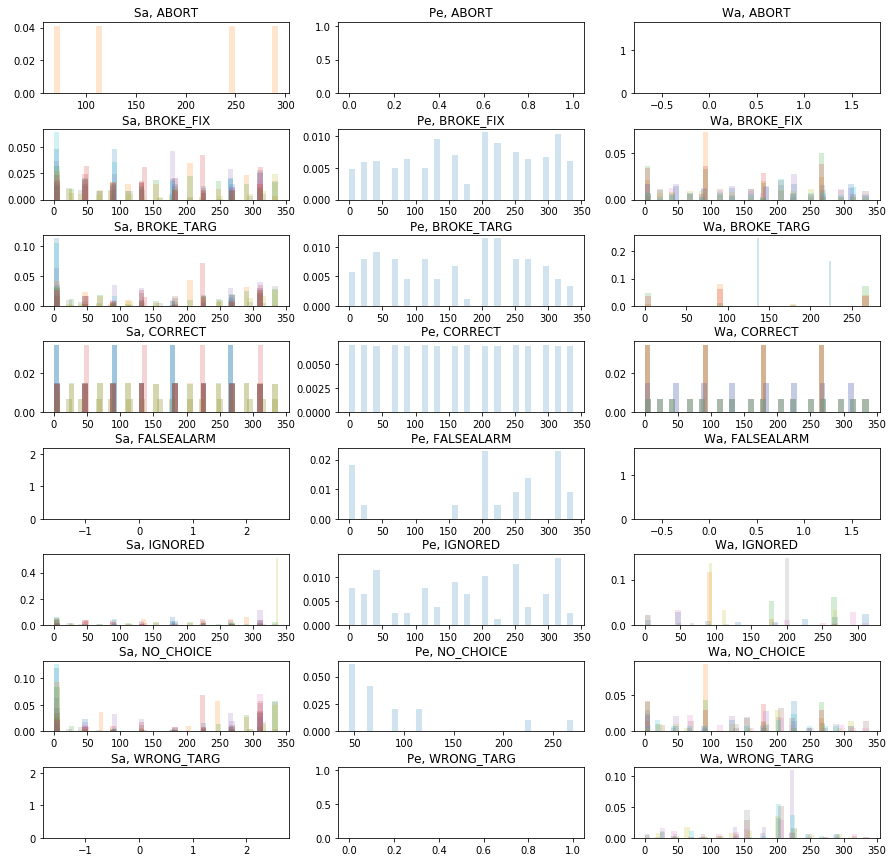

In [19]:
helper=1
outc = np.unique(df_dat['outcome'].values)

plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for out in outc:
    for m in ['Sa','Pe','Wa']:
        plt.subplot(8,3,helper)
        for s in range(max(df_dat['session'].loc[df_dat['monkey']==m])+1):
            plt.hist(df_dat[(df_dat['outcome']==out) & (df_dat['monkey']==m) & (df_dat['session']==s)]['targ_angle'].values, bins=37, alpha=0.2, density=True)
            #plt.hist(circdist(df_dat[(df_dat['outcome']==out) & (df_dat['monkey']==m)]['targ_angle'].values,\
            #                  df_dat[(df_dat['outcome']==out) & (df_dat['monkey']==m)]['saccade_angle'].values))
        plt.title(m+', '+out)
        helper+=1
plt.show()
        

In [1]:
s=1
plt.scatter([df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==s)]['targ_xy'].values[n][0] for n in range(len(df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==s)]['targ_xy'].values))], [df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==s)]['targ_xy'].values[n][1] for n in range(len(df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==s)]['targ_xy'].values))])
np.mean(df_dat.loc[(df_dat['monkey']=='Sa') & (df_dat['session']==s)]['targ_xy'], axis=0)

NameError: name 'plt' is not defined

# Behavioral analysis

## Single trial behavioral analysis

### correct based on mean of saccades = calibration point 

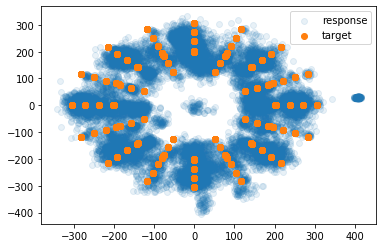

<Figure size 432x288 with 0 Axes>

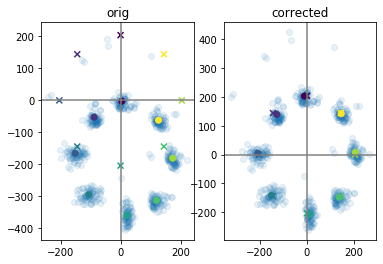

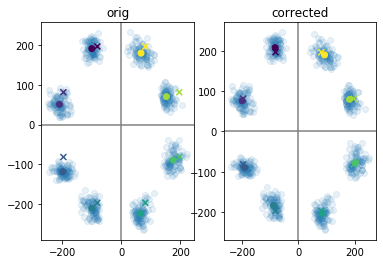

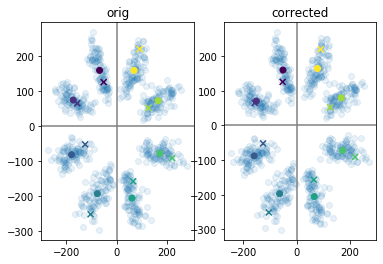

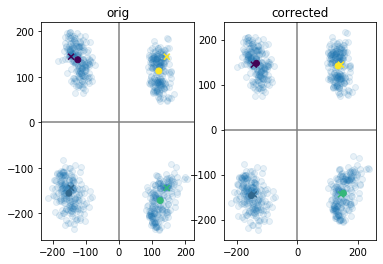

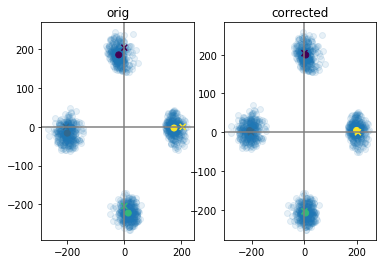

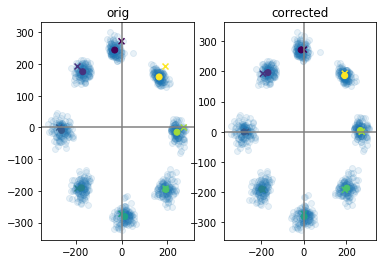

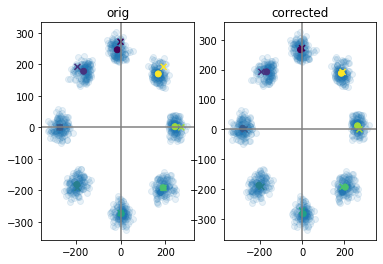

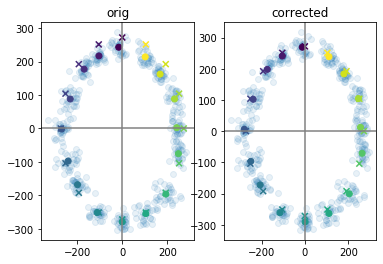

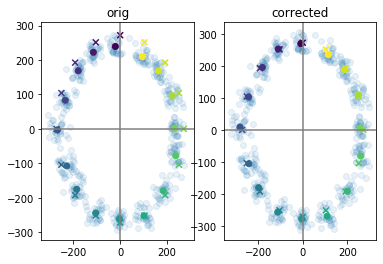

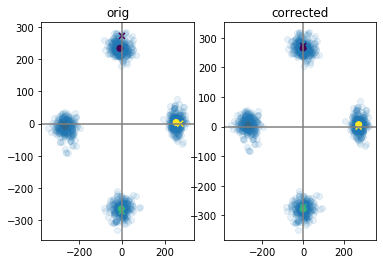

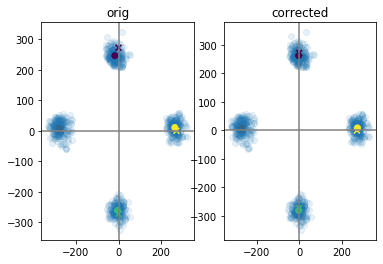

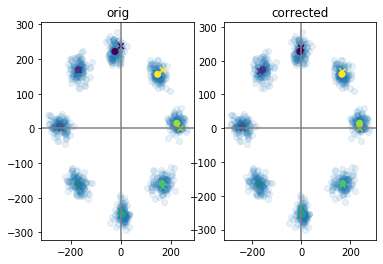

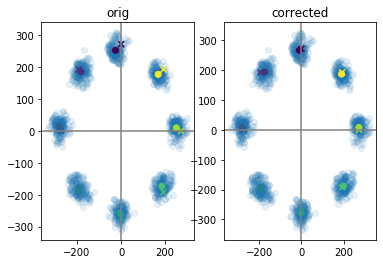

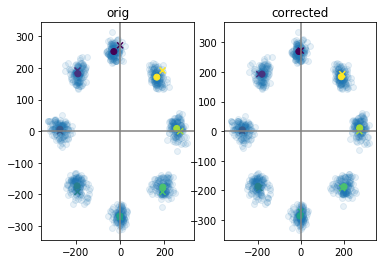

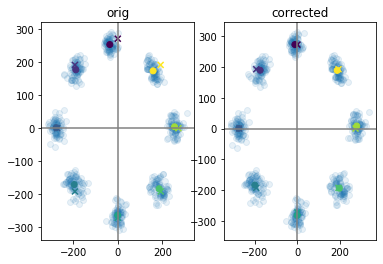

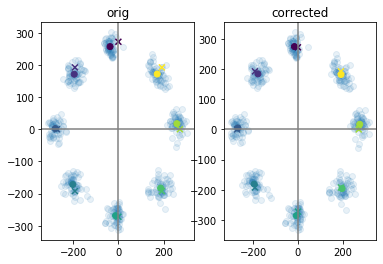

<Figure size 432x288 with 0 Axes>

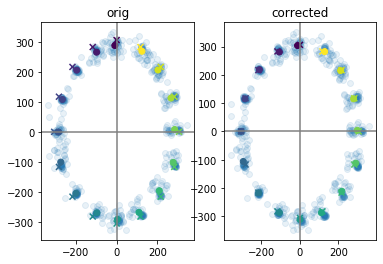

<Figure size 432x288 with 0 Axes>

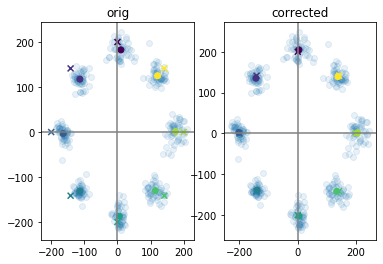

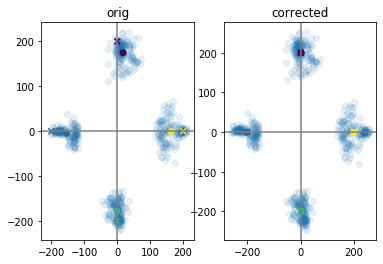

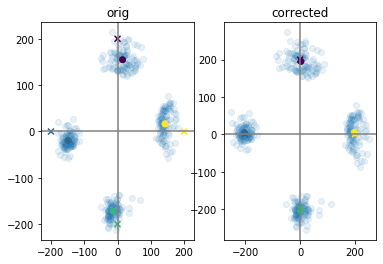

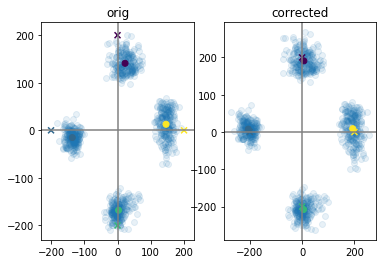

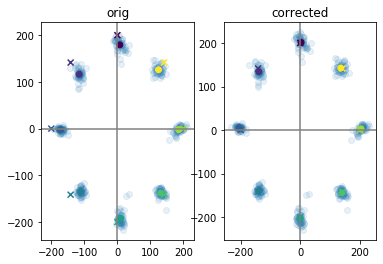

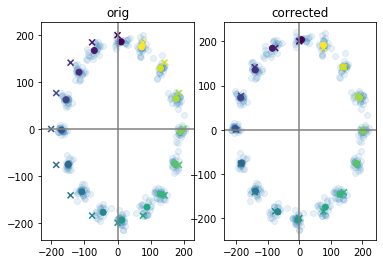

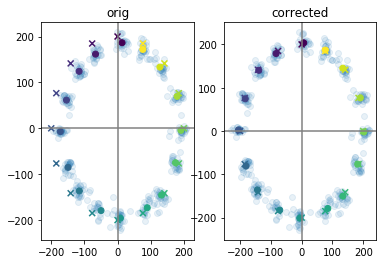

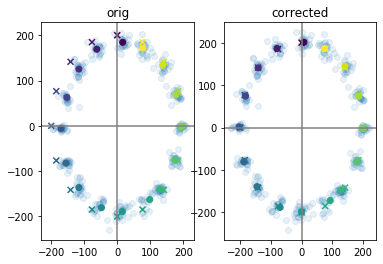

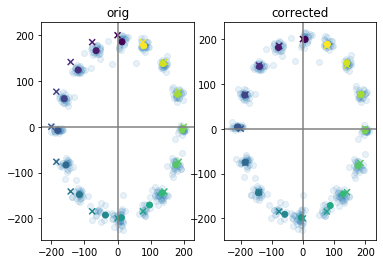

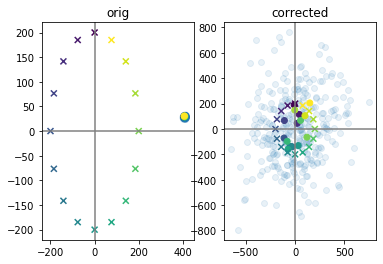

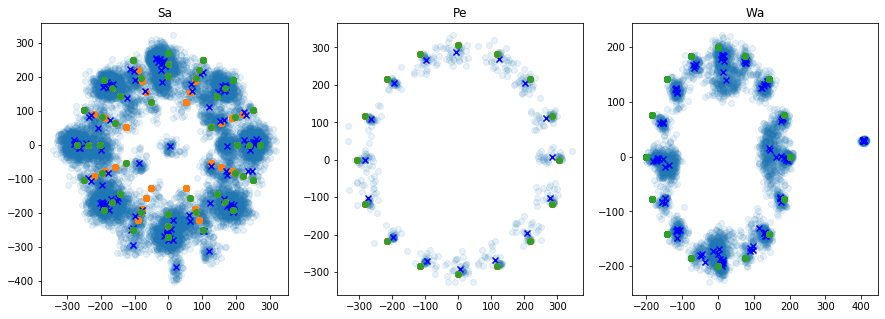

In [8]:
plt.figure()
x_t = [df_dat['targ_xy'].iloc[i][0] for i in df_dat.loc[df_dat['outcome']=='CORRECT'].index] # target coords
y_t = [df_dat['targ_xy'].iloc[i][1] for i in df_dat.loc[df_dat['outcome']=='CORRECT'].index]
x_s = [df_dat['saccade_xy'].iloc[i][0] for i in df_dat.loc[df_dat['outcome']=='CORRECT'].index] # saccade coords
y_s = [df_dat['saccade_xy'].iloc[i][1] for i in df_dat.loc[df_dat['outcome']=='CORRECT'].index]
plt.scatter(x_s,y_s, alpha=0.1, label='response')
plt.scatter(x_t,y_t, label='target')
plt.legend()
plt.show()
    

# determine mean of x/y position for each monkey, each session
mean_x = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_y = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_sac_x = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_sac_y = {'Sa':[], 'Pe':[], 'Wa':[]}
ref_points = {'Sa':[], 'Pe':[], 'Wa':[]}
tsr_points = {'Sa':[], 'Pe':[], 'Wa':[]}
all_points = {'Sa':[], 'Pe':[], 'Wa':[]}
all_new_points_full = {'Sa':[], 'Pe':[], 'Wa':[]}
new_sac = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_helpx = np.full((len(df_dat)), np.nan)
mean_helpy = np.full((len(df_dat)), np.nan)
for m in ['Sa', 'Pe', 'Wa']:
    transf=[]
    ref_centr=[]
    tsr_centr=[]
    plt.figure()
    for n in range(max(df_dat['session'].loc[df_dat['monkey']==m])+1):
        df_dat_sess = df_dat[(df_dat['outcome']=='CORRECT') & ((df_dat['monkey']==m) & (df_dat['session']==n))]

        ## mean of error (sac) for chosen session of monkey
        #mean_x[m].append(np.mean([df_dat['saccade_xy'].iloc[i][0]-df_dat['targ_xy'].iloc[i][0] for i in df_dat[((df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)) & (df_dat['session']==n)].index]))
        ## mean of y (sac) for chosen session of monkey
        #mean_y[m].append(np.mean([df_dat['saccade_xy'].iloc[i][1]-df_dat['targ_xy'].iloc[i][1] for i in df_dat[((df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)) & (df_dat['session']==n)].index])) 
        
        # for each traget position separately
        mean_sx=[]
        mean_sy=[]

        targ_keys = list(df_dat[((df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)) & (df_dat['session']==n)].groupby(['targ_angle']).groups)
        #targ_keys_xy = list(df_dat[((df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)) & (df_dat['session']==n)].groupby(['targ_xy']).groups)
        
        # for each target position determine mean response position as calibration points
        for group in range(len(targ_keys)): 
            df_dat_trial = df_dat_sess[df_dat_sess['targ_angle']==targ_keys[group]]
            mean_sx.append(np.mean([df_dat['saccade_xy'].iloc[i][0] for i in df_dat_trial.index]))
            mean_sy.append(np.mean([df_dat['saccade_xy'].iloc[i][1] for i in df_dat_trial.index]))
        mean_sac_x[m].append(mean_sx)
        mean_sac_y[m].append(mean_sy)
        
        ref_x = [df_dat_sess[df_dat_sess['targ_angle']==key]['targ_xy'].iloc[0][0] for key in targ_keys]
        ref_y = [df_dat_sess[df_dat_sess['targ_angle']==key]['targ_xy'].iloc[0][1] for key in targ_keys]
        ## create mean-corrected saccade points
        #for sac_pts in df_dat[(df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m) & (df_dat['session']==n)].index:
        #    mean_helpx[sac_pts] = df_dat['saccade_xy'][sac_pts][0]-mean_x[m][n]
        #    mean_helpy[sac_pts] = df_dat['saccade_xy'][sac_pts][1]-mean_y[m][n]

        # create TRANSFORM
        #ref_points[m].append(np.array([[df_dat[((df_dat['targ_angle']==targ_keys[g]) & (df_dat['outcome']=='CORRECT')) & ((df_dat['monkey']==m) & (df_dat['session']==n))]['targ_xy'][0], df_dat_trial['targ_xy'][1]] for g in range(len(targ_keys))]))
        ref_points[m].append(np.array(list(zip(ref_x, ref_y))))
        tsr_points[m].append(np.array(list(zip(mean_sx, mean_sy))))
        
        # saccade angle x,y
        sx = [df_dat_sess['saccade_xy'][i][0] for i in df_dat_sess.index]
        sy = [df_dat_sess['saccade_xy'][i][1] for i in df_dat_sess.index]
        all_points[m].append(np.array(list(zip(sx, sy))))

        
        # get the affine transformations that map mean eye tracker data to reference points
        translation, transformation = compute_affine_transform(ref_points[m][n], tsr_points[m][n])

        transf.append(transformation) #save for transformation of data points later

        # now get the centroid in each condition for recentering
        ref_centroid = np.mean(ref_points[m][n], axis=0)
        tsr_centroid = np.mean(tsr_points[m][n], axis=0)
        ref_centr.append(ref_centroid) #save for transformation of data points later
        tsr_centr.append(tsr_centroid) #save for transformation of data points later

        # remap the eye tracker data using the transformation
        new_points = np.empty_like(ref_points[m][n])
        all_new_points = np.empty_like(all_points[m][n])
        for j in range(len(targ_keys)):
            new_points[j] = ref_centroid + np.dot(transformation, tsr_points[m][n][j] - tsr_centroid)
        for i in range(len(all_new_points)):
            all_new_points[i] = ref_centroid + np.dot(transformation, all_points[m][n][i] - tsr_centroid)
        
        all_new_points_full[m].append(all_new_points)
        new_sac[m].append(new_points)
        # visualize the match
        plt.figure()
        plt.subplot(121)
        plt.axhline(0, color='grey')
        plt.axvline(0, color='grey')
        plt.scatter(all_points[m][n][:,0], all_points[m][n][:,1], alpha=0.1)
        plt.scatter(mean_sac_x[m][n], mean_sac_y[m][n], c=targ_keys)
        plt.scatter(ref_points[m][n][:,0], ref_points[m][n][:,1], c=targ_keys, marker='x')
        plt.title('orig')
        
        plt.subplot(122)
        plt.axhline(0, color='grey')
        plt.axvline(0, color='grey')
        plt.scatter(all_new_points[:,0], all_new_points[:,1], alpha=0.1)
        plt.scatter(new_points[:,0], new_points[:,1], c=targ_keys)
        plt.scatter(ref_points[m][n][:,0], ref_points[m][n][:,1], c=targ_keys, marker='x')
        plt.title('corrected')
        plt.show()

## FROM NOW ON ONLY CONTAINS MEAN CENTERED DATA
#angles = convert_cm2deg(np.concatenate(sum(all_new_points_full.values(), []))[:,0], np.concatenate(sum(all_new_points_full.values(), []))[:,1])
##df_dat['saccade_xy'] = np.concatenate(sum(new_sac.values(), []))#list(zip(mean_helpx, mean_helpy))
#for j,i in enumerate(df_dat.loc[np.where(df_dat['outcome']=='CORRECT')].index):
#    df_dat['saccade_xy'][i] = np.concatenate(sum(all_new_points_full.values(), []))[j]
#    df_dat['saccade_angle'][i] = angles[j]
    
            
# plot REGULAR RESPONSES for each monkey separately
plt.figure(figsize=(15,5))
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.subplot(1,3,i+1)
    x_t = [df_dat['targ_xy'].iloc[i][0] for i in df_dat[(df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)].index]
    y_t = [df_dat['targ_xy'].iloc[i][1] for i in df_dat[(df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)].index]
    x_s = [df_dat['saccade_xy'].iloc[i][0] for i in df_dat[(df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)].index]
    y_s = [df_dat['saccade_xy'].iloc[i][1] for i in df_dat[(df_dat['outcome']=='CORRECT') & (df_dat['monkey']==m)].index]
    plt.scatter(x_s,y_s, alpha=0.1, label='response')
    plt.scatter(x_t,y_t, label='target')
    plt.scatter(np.concatenate(mean_sac_x[m]), np.concatenate(mean_sac_y[m]), color='blue', marker='x')
    plt.scatter(np.concatenate(ref_points[m])[:,0], np.concatenate(ref_points[m])[:,1])
    plt.title(m)
    

## FROM NOW ON ONLY CONTAINS MEAN CENTERED DATA
#df_dat['saccade_xy'] = list(zip(mean_helpx, mean_helpy))
#df_dat['saccade_angle'] = convert_cm2deg(mean_helpx, mean_helpy)

#for incorr in np.where(df_dat['saccade_xy']==(0,0))[0]:
#    df_dat.loc[incorr,'saccade_xy']=[]
#    df_dat.loc[incorr,'saccade_angle']=[]

#df_dat.head()

# plot CORRECTED DATA
#plt.figure(figsize=(15,5))
#for i,m in enumerate(['Sa', 'Pe', 'Wa']):
#    plt.subplot(1,3,i+1)
#    x_t = [df_dat['targ_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
#    y_t = [df_dat['targ_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
#    x_s = [df_dat['saccade_xy'].iloc[i][0] for i in np.where(df_dat['monkey']==m)[0]]
#    y_s = [df_dat['saccade_xy'].iloc[i][1] for i in np.where(df_dat['monkey']==m)[0]]
#    plt.scatter(x_s,y_s, alpha=0.1, label='response')
#    plt.scatter(x_t,y_t, label='target')
#    plt.title(m)



### correct through matrix calculated on each point to target

575


<Figure size 432x288 with 0 Axes>

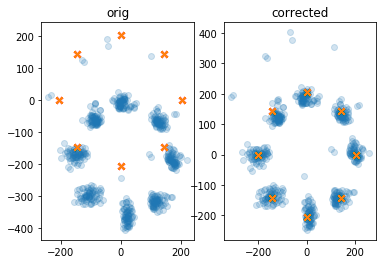

748


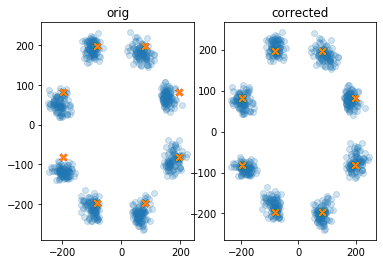

780


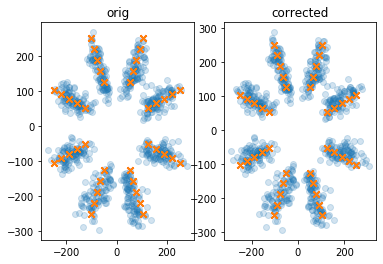

825


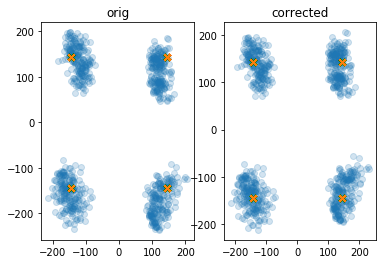

1258


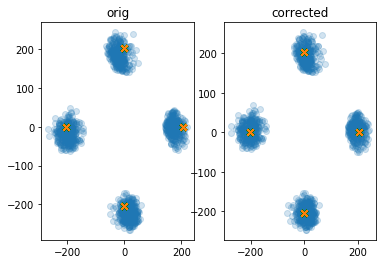

974


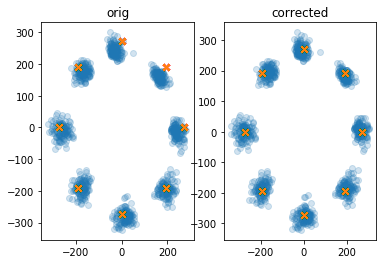

1093


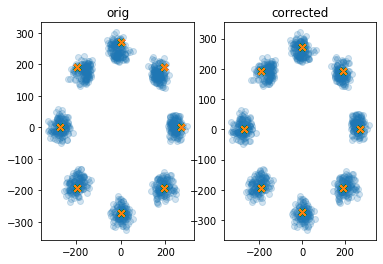

502


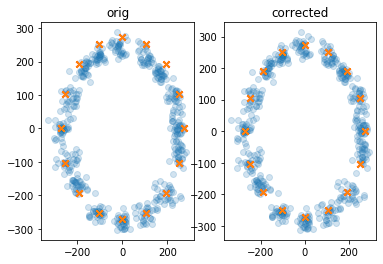

479


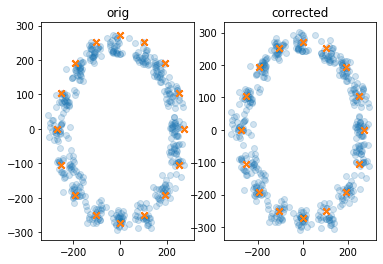

1143


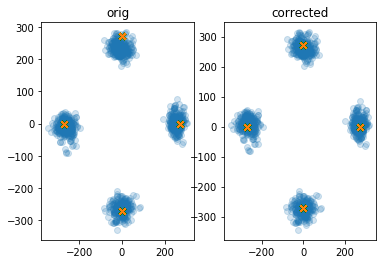

774


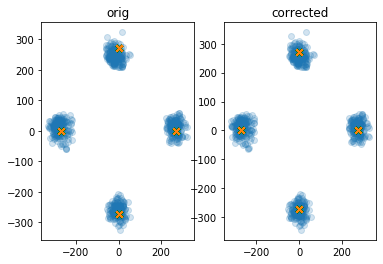

956


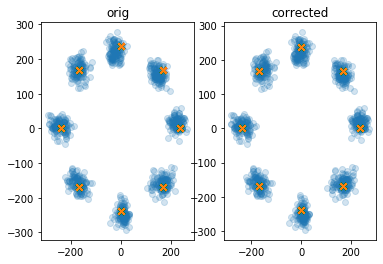

1384


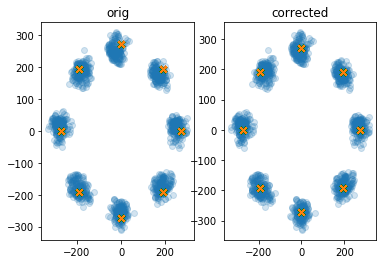

1025


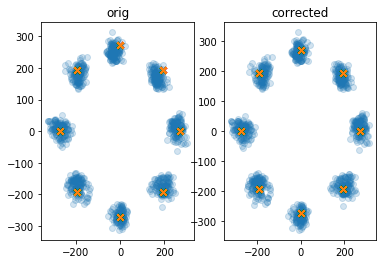

623


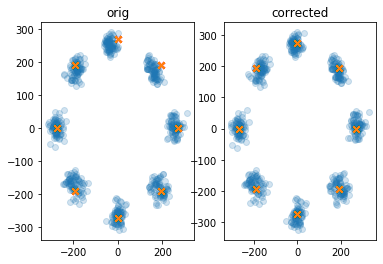

462


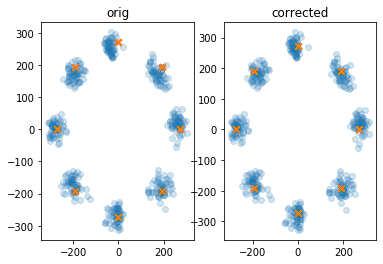

647


<Figure size 432x288 with 0 Axes>

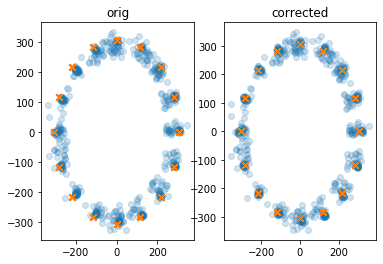

400


<Figure size 432x288 with 0 Axes>

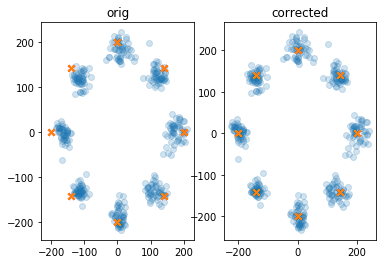

615


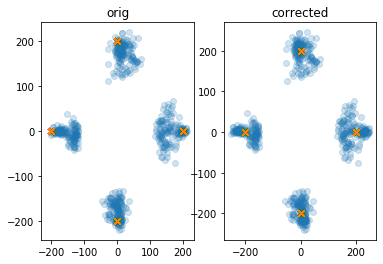

400


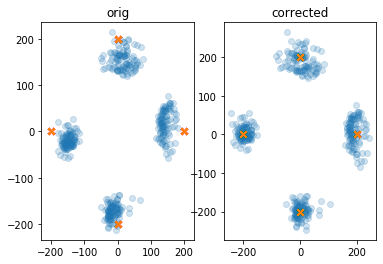

900


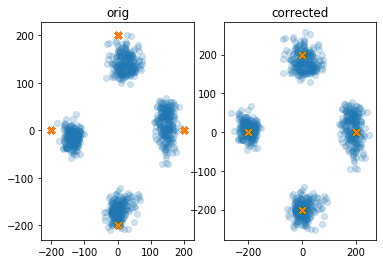

400


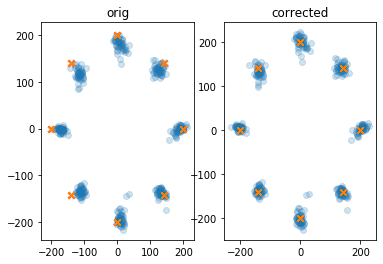

400


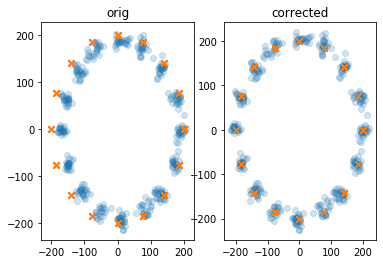

400


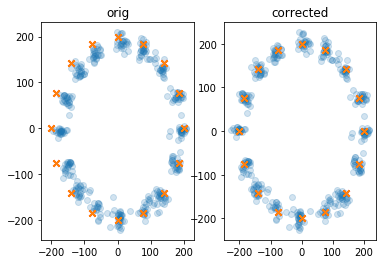

400


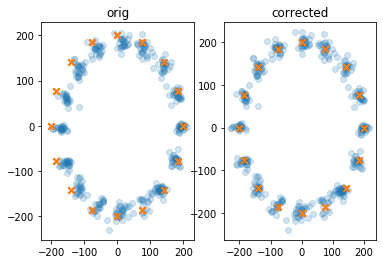

400


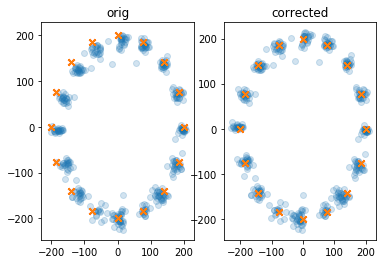

320


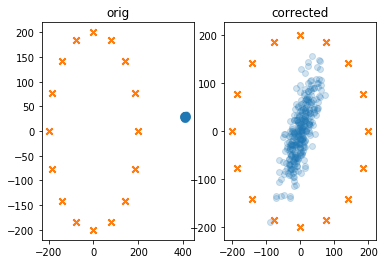

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [9]:

# determine mean of x/y position for each monkey, each session
mean_x = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_y = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_sac_x = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_sac_y = {'Sa':[], 'Pe':[], 'Wa':[]}
ref_points = {'Sa':[], 'Pe':[], 'Wa':[]}
tsr_points = {'Sa':[], 'Pe':[], 'Wa':[]}
new_sac = {'Sa':[], 'Pe':[], 'Wa':[]}
mean_helpx = np.full((len(df_dat)), np.nan)
mean_helpy = np.full((len(df_dat)), np.nan)
for m in ['Sa', 'Pe', 'Wa']:
    transf=[]
    ref_centr=[]
    tsr_centr=[]
    plt.figure()
    for n in range(max(df_dat['session'].loc[df_dat['monkey']==m])+1):      
        df_dat_trial = df_dat[((df_dat['outcome']=='CORRECT')) & ((df_dat['monkey']==m) & (df_dat['session']==n))]
        
        targ_keys = list(df_dat_trial.groupby(['targ_angle']).groups)        
        
        ref_x = [df_dat['targ_xy'].iloc[i][0] for i in df_dat_trial.index]
        ref_y = [df_dat['targ_xy'].iloc[i][1] for i in df_dat_trial.index]

        # create TRANSFORM
        #ref_points[m].append(np.array([[df_dat[((df_dat['targ_angle']==targ_keys[g]) & (df_dat['outcome']=='CORRECT')) & ((df_dat['monkey']==m) & (df_dat['session']==n))]['targ_xy'][0], df_dat_trial['targ_xy'][1]] for g in range(len(targ_keys))]))
        ref_points[m].append(np.array(list(zip(ref_x, ref_y))))
        tsr_points[m].append(np.array(list(zip([df_dat['saccade_xy'].iloc[i][0] for i in df_dat_trial.index], [df_dat['saccade_xy'].iloc[i][1] for i in df_dat_trial.index]))))

        
        # get the affine transformations that map eye tracker data to reference points
        translation, transformation = compute_affine_transform(ref_points[m][n], tsr_points[m][n])

        transf.append(transformation) #save for transformation of data points later

        # now get the centroid in each condition for recentering
        ref_centroid = np.mean(ref_points[m][n], axis=0)
        tsr_centroid = np.mean(tsr_points[m][n], axis=0)
        ref_centr.append(ref_centroid) #save for transformation of data points later
        tsr_centr.append(tsr_centroid) #save for transformation of data points later

        # remap the eye tracker data using the transformation
        new_points = np.empty_like(ref_points[m][n])
        for j in range(len(new_points)):
            new_points[j] = ref_centroid + np.dot(transformation, tsr_points[m][n][j] - tsr_centroid)
        
        new_sac[m].append(new_points)
        # visualize the match
        print(len(new_points))
        plt.figure()
        plt.subplot(121)
        plt.scatter(tsr_points[m][n][:,0],tsr_points[m][n][:,1], alpha=0.2)
        plt.scatter(ref_points[m][n][:,0], ref_points[m][n][:,1], marker='x')
        plt.title('orig')
        plt.subplot(122)
        plt.scatter(new_points[:,0], new_points[:,1], alpha=0.2)
        plt.scatter(ref_points[m][n][:,0], ref_points[m][n][:,1], marker='x')
        plt.title('corrected')
        plt.show()

    
## FROM NOW ON ONLY CONTAINS MEAN CENTERED DATA
angles = convert_cm2deg(np.concatenate(sum(new_sac.values(), []))[:,0], np.concatenate(sum(new_sac.values(), []))[:,1])
#df_dat['saccade_xy'] = np.concatenate(sum(new_sac.values(), []))#list(zip(mean_helpx, mean_helpy))
for j,i in enumerate(df_dat.loc[np.where(df_dat['outcome']=='CORRECT')].index):
    df_dat['saccade_xy'][i] = np.concatenate(sum(new_sac.values(), []))[j]
    df_dat['saccade_angle'][i] = angles[j]
    


In [10]:
df_dat.head()

trial_id                                           sp_train    outcome  \
0         1    (84, 0)\t1.0\n  (151, 0)\t1.0\n  (131, 1)\t1...    CORRECT   
1         2    (1, 0)\t1.0\n  (40, 0)\t1.0\n  (47, 0)\t1.0\...  BROKE_FIX   
2         3    (96, 0)\t1.0\n  (2, 1)\t1.0\n  (27, 1)\t1.0\...    CORRECT   
3         4    (86, 0)\t1.0\n  (10, 1)\t1.0\n  (61, 1)\t1.0...    CORRECT   
4         5    (0, 0)\t1.0\n  (91, 0)\t1.0\n  (136, 1)\t1.0...    CORRECT   

                                     targ_xy  targ_angle  \
0  [-144.24978336205572, -144.2497833620557]       135.0   
1    [-144.2497833620557, 144.2497833620557]        45.0   
2           [-204.0, 2.4982794702606005e-14]        90.0   
3  [144.24978336205567, -144.24978336205572]       225.0   
4    [-144.2497833620557, 144.2497833620557]        45.0   

                                 saccade_xy  saccade_angle monkey  session  \
0   [-268.5938978085612, 8.520088823230425]      88.183125     Sa        0   
1                                        []            NaN     Sa        0   
2  [-313.9813469281831, 187.61215008071417]      59.140567     Sa        0   
3   [112.83042510513779, 7.255286910789209]     273.679201     Sa        0   
4   [-166.1027428296741, 317.9668082256232]      27.582125     Sa        0   

   start    fix  targ_on  targ_off  go_cue  saccade  reward  trial_end  \
0    1.0  399.0    617.0    1037.0  3557.0   3792.0  3902.0       4708   
1    1.0   60.0    118.0     118.0   118.0    118.0   118.0       2195   
2    1.0  164.0    383.0     803.0  3223.0   3404.0  3514.0       4289   
3    1.0  170.0    383.0     803.0  2823.0   3014.0  3126.0       3901   
4    1.0   64.0    282.0     702.0  2822.0   3002.0  3117.0       3889   

  hemifield  broke  
0      left  False  
1      left   True  
2      left  False  
3     right  False  
4      left  False

In [11]:
df_dat_corr = df_dat.loc[df_dat['outcome']=='CORRECT'].copy()

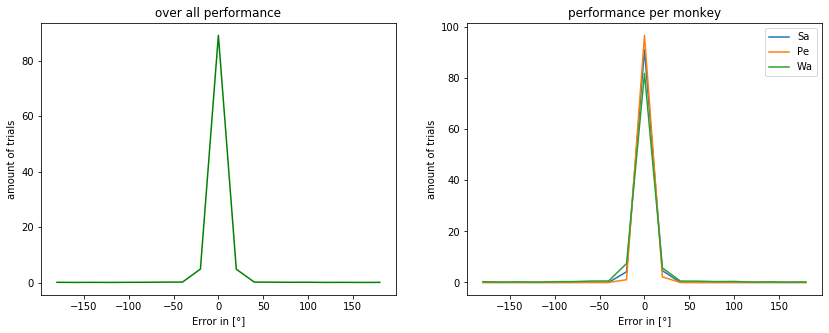

In [12]:

behavior_single = {'err': [], 'delay': []}
behavior_single['err'] = circdist(df_dat_corr['targ_angle'].values*np.pi/180,df_dat_corr['saccade_angle'].values*np.pi/180)*180/np.pi # response offset
behavior_single['delay'] = df_dat_corr['go_cue']-df_dat_corr['targ_off'] # delay time
behavior_single = pd.DataFrame.from_dict(behavior_single)
#print('min delay : '+str(behavior['delay_prev'].min())) # 1528
#print('max delay : '+str(behavior['delay_prev'].max())) # 3050

b_num = 20
b = np.linspace(-180,180,b_num)
histo_full=np.histogram(behavior_single['err'], bins=b)
histo_sep = {'Sa':[],'Pe': [],'Wa':[]}
for m in ['Sa', 'Pe', 'Wa']:
    histo_sep[m]=np.histogram(behavior_single.loc[df_dat_corr[df_dat_corr['monkey']==m].index,'err'], bins=b)

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

plt.plot(np.linspace(-180,180,b_num-1), histo_full[0]*100/len(behavior_single['err']), label='full', color='green')
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.title('over all performance')

plt.subplot(1,2,2)
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep[m][0]*100/len(behavior_single.loc[df_dat_corr[df_dat_corr['monkey']==m].index]), label=m)
plt.xlabel('Error in [°]')
plt.ylabel('amount of trials')
plt.title('performance per monkey')
plt.legend()
plt.show()

#plt.figure()
#for i,m in enumerate(['Sa', 'Pe', 'Wa']):
#    plt.plot(np.linspace(-180,180,b_num-1), histo_sep[m][0]*100/len(behavior_single.loc[df_dat_corr[df_dat_corr['monkey']==m].index]), label=m)
#plt.xlabel('Error in [°]')
#plt.ylabel('amount of trials')
#plt.title('response accuracy')
#plt.legend()
##plt.savefig('../Figures/Histogram_responseAcc.png', dpi=100)
#plt.show()

In [13]:
print('err maximum = '+str(max(behavior_single['err'])))
print('err minimum = '+str(min(behavior_single['err'])))


err maximum = 178.7706146594269
err minimum = -179.95338126659058


#### Delay dependence, repsonse offset

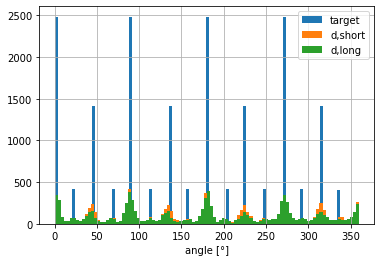

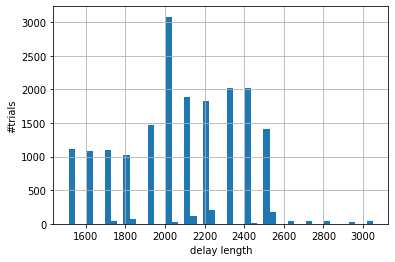

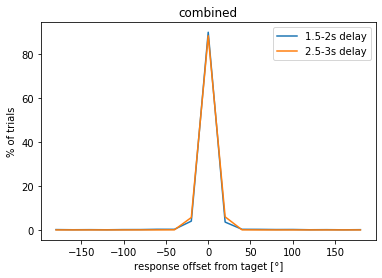

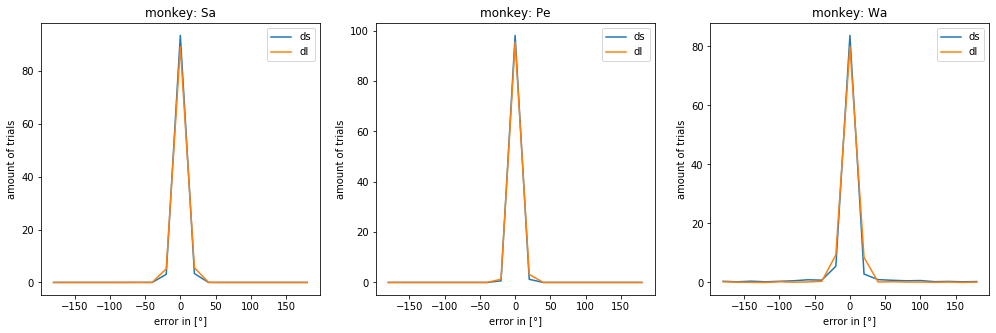

In [14]:
# cut-off value for long VS short delay
cut = np.median(behavior_single['delay'])
cut_split = []
cut_split_sess=[]
for m in ['Sa', 'Pe', 'Wa']:
    cut_split.append(np.median(behavior_single['delay'].values[np.where(df_dat_corr['monkey']==m)]))
    for n in range(max(df_dat_corr.loc[df_dat_corr['monkey']==m]['session'].values)+1):
        cut_split_sess.append(np.median(behavior_single['delay'].values[np.where((df_dat_corr['monkey']==m) & (df_dat_corr['session']==n))]))
    
# plot targets, responses short VS long
plt.figure()
#plt.subplot(1,2,1)
df_dat_corr['targ_angle'].hist(bins=100, label='target')#df_dat['targ_angle'].hist(bins=b, label='target')
df_dat_corr[(behavior_single['delay']<cut)]['saccade_angle'].hist(bins=100, label='d,short')#df_dat['saccade_angle'].hist(bins=b, label='target')
df_dat_corr[(behavior_single['delay']>cut)]['saccade_angle'].hist(bins=100, label='d,long')#df_dat['saccade_angle'].hist(bins=b, label='target')
#plt.title('short delay')
plt.xlabel('angle [°]')
plt.legend()
#plt.subplot(1,2,2)
#df_dat.loc[(behavior_single['delay']>cut)]['targ_angle'].hist(bins=100, label='target')#df_dat['targ_angle'].hist(bins=b, label='target')
#df_dat[(behavior_single['delay']>cut)]['saccade_angle'].hist(bins=100, label='saccade')#df_dat['saccade_angle'].hist(bins=b, label='target')
#plt.title('long delay')
#plt.xlabel('angle [°]')
#plt.legend()
#plt.show()

# check histogram -> fairly equally spaced delays
plt.figure()
behavior_single['delay'].hist(bins=50)#
plt.xlabel('delay length')
plt.ylabel('#trials')
plt.show()

# determine long/short delays
err_ds = behavior_single.loc[(behavior_single['delay']<cut)]['err']
err_dl = behavior_single.loc[(behavior_single['delay']>cut)]['err']
hist_err_ds = np.histogram(err_ds, bins=b)# bins=b, for Trübutschek plot
hist_err_dl = np.histogram(err_dl, bins=b)# bins=b,

histo_sep_ds = {'Sa':[],'Pe': [],'Wa':[]}
histo_sep_dl = {'Sa':[],'Pe': [],'Wa':[]}
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    # histogram for each monkey for long/short delays
    histo_sep_ds[m]=np.histogram(behavior_single.loc[(behavior_single['delay']<cut_split[i])]['err'].values[np.where(df_dat_corr.loc[(behavior_single['delay']<cut_split[i])]['monkey']==m)[0]], bins=b)
    histo_sep_dl[m]=np.histogram(behavior_single.loc[(behavior_single['delay']>cut_split[i])]['err'].values[np.where(df_dat_corr.loc[(behavior_single['delay']>cut_split[i])]['monkey']==m)[0]], bins=b)


b2 = np.linspace(-180,180,b_num-1)
# response offset
plt.figure()
# behavior['err_prev'].hist(bins=b,histtype='step', density=True, grid=False) # all trials
# seperate trials by delay length
plt.plot(b2, hist_err_ds[0]*100/np.sum(hist_err_ds[0]), label='1.5-2s delay')
plt.plot(b2, hist_err_dl[0]*100/np.sum(hist_err_dl[0]), label='2.5-3s delay')
plt.xlabel('response offset from taget [°]')
plt.ylabel('% of trials')
plt.title('combined')
plt.legend()
plt.show()

plt.figure(figsize=(17,5))
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.subplot(1,3,i+1)
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep_ds[m][0]*100/np.sum(histo_sep_ds[m][0]), label='ds')
    plt.plot(np.linspace(-180,180,b_num-1), histo_sep_dl[m][0]*100/np.sum(histo_sep_dl[m][0]), label='dl')
    plt.title('monkey: '+str(m))
    plt.xlabel('error in [°]')
    plt.ylabel('amount of trials')
    plt.legend()
#plt.savefig('../Figures/histogram_delay_dependence_monkeys.png', dpi=150)
plt.show()


for each session

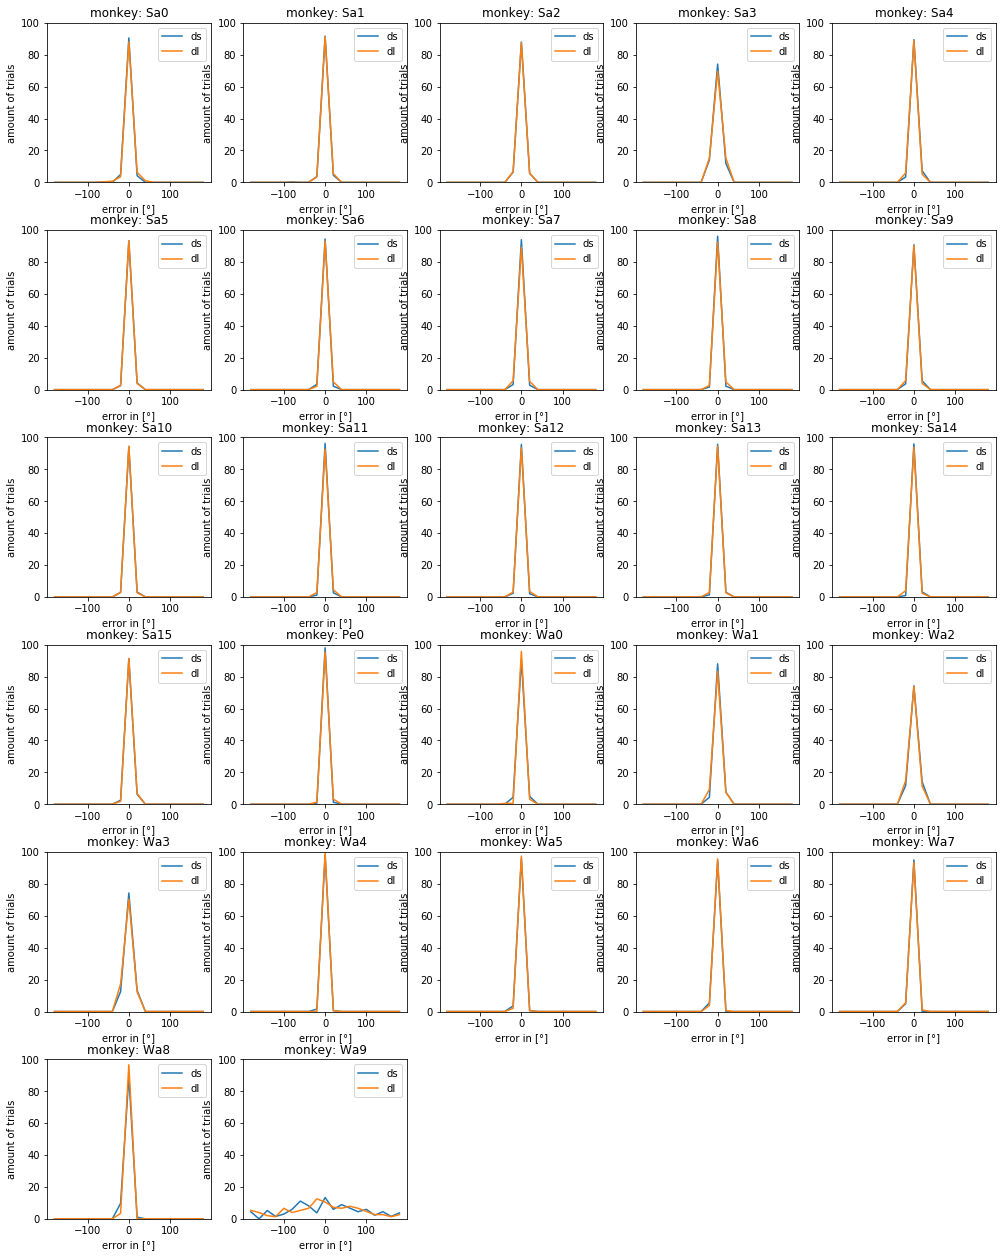

In [15]:

plt.figure(figsize=(17,22))
plt.subplots_adjust(hspace=0.3)
helper=1
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    for n in range(max(df_dat_corr.loc[df_dat_corr['monkey']==m]['session'].values)+1):# for each session

        # histogram for each monkey for long/short delays
        histo_sess_ds=np.histogram(behavior_single.loc[(behavior_single['delay']<cut_split_sess[helper-1]) & (df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)]['err'], bins=b)
        histo_sess_dl=np.histogram(behavior_single.loc[(behavior_single['delay']>cut_split_sess[helper-1]) & (df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)]['err'], bins=b)


        plt.subplot(6,5,helper)
        plt.plot(np.linspace(-180,180,b_num-1), histo_sess_ds[0]*100/np.sum(histo_sess_ds[0]), label='ds')
        plt.plot(np.linspace(-180,180,b_num-1), histo_sess_dl[0]*100/np.sum(histo_sess_dl[0]), label='dl')
        plt.title('monkey: '+str(m)+str(n))
        plt.xlabel('error in [°]')
        plt.ylabel('amount of trials')
        plt.ylim(0,100)
        plt.legend()
        
        helper+=1
#plt.savefig('../Figures/histogram_delay_dependence_monkeys.png', dpi=150)
plt.show()


In [16]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    print('Monkey '+str(m)+': '+str(spearmanr((behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'err']).values**2, behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'])))


Monkey Sa: SpearmanrResult(correlation=0.0676547004914232, pvalue=2.824128912419621e-15)
Monkey Pe: SpearmanrResult(correlation=0.013054910631797345, pvalue=0.7403127215708172)
Monkey Wa: SpearmanrResult(correlation=0.150507014731609, pvalue=6.8571229784169005e-25)


In [17]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    for n in range(max(df_dat_corr.loc[df_dat_corr['monkey']==m]['session'].values)+1):
        print('Monkey '+str(m)+str(n)+': '+str(spearmanr(behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)].index,'delay'].values, abs(behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)].index,'err']).values)))
        

Monkey Sa0: SpearmanrResult(correlation=-0.004487043301938315, pvalue=0.9145018621579878)
Monkey Sa1: SpearmanrResult(correlation=0.04682675571259434, pvalue=0.20080816731595527)
Monkey Sa2: SpearmanrResult(correlation=-0.0406806130945865, pvalue=0.25646106532696933)
Monkey Sa3: SpearmanrResult(correlation=0.06412129563088453, pvalue=0.06564410404326537)
Monkey Sa4: SpearmanrResult(correlation=0.010142831213047841, pvalue=0.7192954585339131)
Monkey Sa5: SpearmanrResult(correlation=0.04260098504419728, pvalue=0.18403649015329412)
Monkey Sa6: SpearmanrResult(correlation=0.051617102147653936, pvalue=0.0880687443820265)
Monkey Sa7: SpearmanrResult(correlation=0.03443507220315205, pvalue=0.4413977437645652)
Monkey Sa8: SpearmanrResult(correlation=0.05391417763984379, pvalue=0.23889901497194327)
Monkey Sa9: SpearmanrResult(correlation=0.05753273877349022, pvalue=0.051827272706789156)
Monkey Sa10: SpearmanrResult(correlation=0.012385415309572496, pvalue=0.7308243639337086)
Monkey Sa11: Spearm

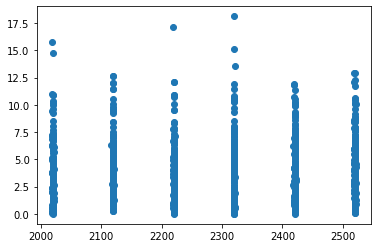

In [18]:
m='Sa'
n=5
plt.scatter(behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)].index,'delay'].values,abs(behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m) & (df_dat_corr['session']==n)].index,'err']).values)

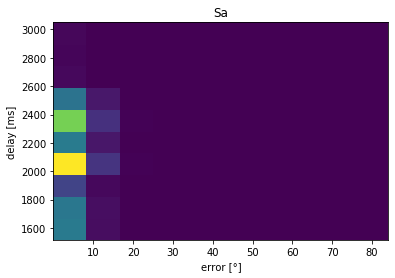

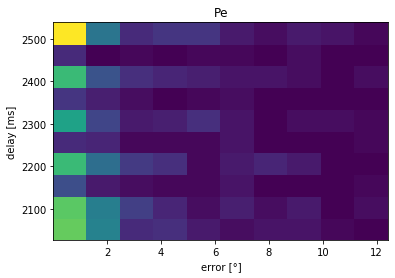

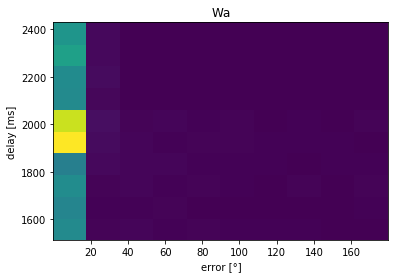

In [19]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    plt.figure()
    plt.hist2d(abs(behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'err'].values), behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'].values,density=True);
    plt.title(m)
    plt.xlabel('error [°]')
    plt.ylabel('delay [ms]')
    plt.show()


xerr vs delay Sa : SpearmanrResult(correlation=0.050663080507972996, pvalue=3.3849154046486063e-09)
yerr vs delay Sa : SpearmanrResult(correlation=0.019302373195536928, pvalue=0.024378586678891808)
xerr+yerr vs delay Sa : SpearmanrResult(correlation=0.05159420191364711, pvalue=1.7383171082589089e-09)


<Figure size 432x288 with 0 Axes>

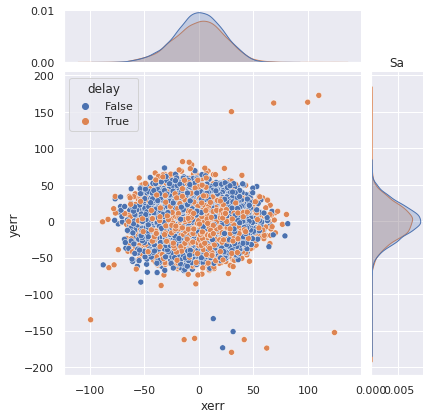

xerr vs delay Pe : SpearmanrResult(correlation=0.04248192847535808, pvalue=0.28059833569275483)
yerr vs delay Pe : SpearmanrResult(correlation=0.0659284315491177, pvalue=0.09382658311232926)
xerr+yerr vs delay Pe : SpearmanrResult(correlation=0.05096980716988345, pvalue=0.19538487623338868)


<Figure size 432x288 with 0 Axes>

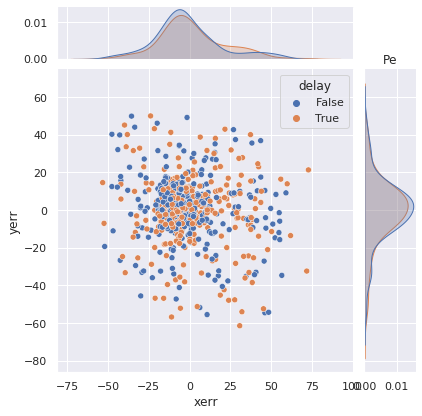

xerr vs delay Wa : SpearmanrResult(correlation=0.16497965209200688, pvalue=1.2188185272450275e-29)
yerr vs delay Wa : SpearmanrResult(correlation=0.17087299292770122, pvalue=1.051636165037038e-31)
xerr+yerr vs delay Wa : SpearmanrResult(correlation=0.2556907953660164, pvalue=4.3497868297430535e-70)


<Figure size 432x288 with 0 Axes>

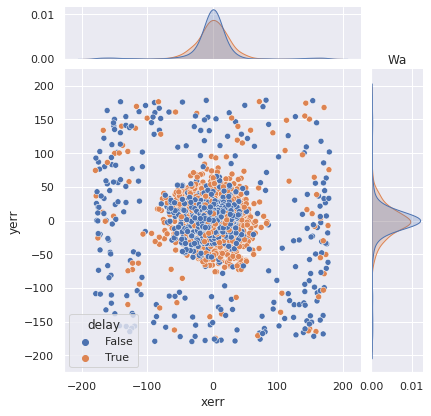

In [20]:
xerr={'Sa':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Sa'])),'Pe':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Pe','targ_xy'])),'Wa':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Wa','targ_xy']))}
yerr={'Sa':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Sa'])),'Pe':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Pe','targ_xy'])),'Wa':np.zeros(len(df_dat_corr.loc[df_dat_corr['monkey']=='Wa','targ_xy']))}

for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    for count,s in enumerate(df_dat_corr.loc[df_dat_corr['monkey']==m].index):# each trial for only one monkey
        xerr[m][count] = circdist(df_dat_corr['targ_xy'][s][0]*np.pi/180, df_dat_corr['saccade_xy'][s][0]*np.pi/180)*180/np.pi
        yerr[m][count] = circdist(df_dat_corr['targ_xy'][s][1]*np.pi/180, df_dat_corr['saccade_xy'][s][1]*np.pi/180)*180/np.pi

    print('xerr vs delay '+str(m)+' : '+str(spearmanr((xerr[m])**2, behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'].values)))
    print('yerr vs delay '+str(m)+' : '+str(spearmanr((yerr[m])**2, behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'].values)))
    print('xerr+yerr vs delay '+str(m)+' : '+str(spearmanr((xerr[m])**2+(yerr[m])**2, behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'].values)))

    xy = {'xerr': xerr[m], 'yerr': yerr[m], 'delay': behavior_single.loc[df_dat_corr[(df_dat_corr['monkey']==m)].index,'delay'].values>cut_split[i]}
    df_xy = pd.DataFrame(xy)

    plt.figure()
    sns.set_theme()
    XYpos = sns.jointplot(data=df_xy, x="xerr", y="yerr", hue="delay", marginal_ticks=True)# short delay=False, long delay=True
    plt.title(m)
    plt.show()


##### Dependence #trials on delay?

In [21]:
spearmanr(behavior_single.groupby(['delay'])['delay'].count(), list(behavior_single.groupby(['delay']).groups))

SpearmanrResult(correlation=-0.15511128363881266, pvalue=0.024234393081289243)

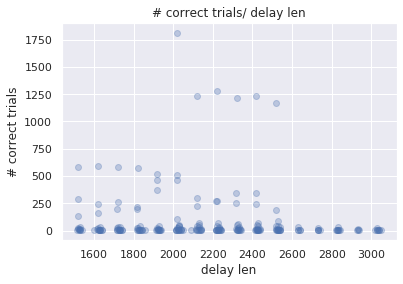

In [22]:
plt.figure()
plt.scatter(list(behavior_single.groupby(['delay']).groups), behavior_single.groupby(['delay'])['delay'].count(), alpha=0.3)
plt.title('# correct trials/ delay len')
plt.xlabel('delay len')
plt.ylabel('# correct trials')
#plt.plot(behavior_single.groupby(['delay']).mean())
plt.show()

# Serial bias analysis

### Serial dependence

In [23]:
df_dat.groupby(['outcome']).groups.keys()

dict_keys(['ABORT', 'BROKE_FIX', 'BROKE_TARG', 'CORRECT', 'FALSEALARM', 'IGNORED', 'NO_CHOICE', 'WRONG_TARG'])

In [24]:
df_dat.groupby(['outcome'])['reward'].mean()

outcome
ABORT          779.000000
BROKE_FIX     1089.387643
BROKE_TARG    3190.385874
CORRECT       3238.180586
FALSEALARM    3454.416667
IGNORED       1156.379299
NO_CHOICE     3096.665788
WRONG_TARG    3030.968807
Name: reward, dtype: float64

In [25]:
df_dat.groupby(['outcome'])['reward'].max()

outcome
ABORT          783.0
BROKE_FIX     4035.0
BROKE_TARG    4474.0
CORRECT       4901.0
FALSEALARM    3811.0
IGNORED       1500.0
NO_CHOICE     4359.0
WRONG_TARG    3461.0
Name: reward, dtype: float64

In [26]:
## create list with values needed for serial bias calculation (ONLY if two trials are in a row)
## no need to extra specify sessions, trial_id changes from large # to small #
#serial = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'monkey': []}
#for idx in df_dat.index[:-1]:
#    if ((df_dat['outcome'][idx] == 'CORRECT') & (df_dat['outcome'][idx+1]=='CORRECT')):
#        serial['trial_id'].append(idx)
#        serial['target_prev'].append(round(df_dat['targ_angle'][idx]*np.pi/180, 5))
#        serial['response_prev'].append(round(df_dat['saccade_angle'][idx]*np.pi/180, 5))
#        serial['delay_prev'].append(df_dat['go_cue'][idx]-df_dat['targ_off'][idx])
#        serial['target_curr'].append(round(df_dat['targ_angle'][idx+1]*np.pi/180, 5))
#        serial['response_curr'].append(round(df_dat['saccade_angle'][idx+1]*np.pi/180, 5))
#        serial['delay_curr'].append(df_dat['go_cue'][idx+1]-df_dat['targ_off'][idx+1]) 
#        serial['monkey'].append(df_dat['monkey'][idx])#

#rel_loc, err = calc_errorcurve(serial)

#sb = {'rel_loc': rel_loc*180/np.pi, 'err': err*180/np.pi, 'delay_prev': serial['delay_prev'],\
#      'delay_curr': serial['delay_curr'], 'monkey': serial['monkey']}
#df_sb = pd.DataFrame(sb)

#sb_onesided = {'rel_loc': rel_loc*180/np.pi*np.sign(rel_loc),\
#               'err': np.array([err[i]*180/np.pi*np.sign(rel_loc[i]) if rel_loc[i] !=0 else err[i]*180/np.pi for i in range(len(rel_loc))]),\
#               'delay_prev': serial['delay_prev'], 'delay_curr': serial['delay_curr'], 'monkey': serial['monkey']}
#df_sb_onesided = pd.DataFrame(sb_onesided)


serial dependence using cut off time between trials

In [27]:
idx=3
np.all(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['outcome'])=='BROKE_FIX' # only use trials with less than cut_off ms between 2 correct trials


NameError: name 'df_dat_corr_reset' is not defined

In [28]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row)
# no need to extra specify sessions, trial_id changes from large # to small #
serial = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [], 'response_curr': [], 'delay_curr': [], 'ITI':[], 'broke':[], 'monkey': [], 'session':[]}
df_dat_corr_reset = df_dat_corr.reset_index()

cut_off_time=5
for idx in df_dat_corr_reset.index[:-1]:# run through all correct trials (0,len)
    if df_dat_corr_reset.loc[idx,'trial_id'] < df_dat_corr_reset.loc[idx+1,'trial_id']: # only compare within one sesssion
        if np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['trial_end'])<cut_off_time: # only use trials with less than cut_off ms between 2 correct trials
            #print(df_dat.loc[df_dat_corr_reset.loc[idx,'index'], 'outcome'], df_dat.loc[df_dat_corr_reset.loc[idx+1,'index'], 'outcome'])
            serial['trial_id'].append(idx)
            serial['target_prev'].append(round(df_dat_corr_reset['targ_angle'][idx]*np.pi/180, 5))
            serial['response_prev'].append(round(df_dat_corr_reset['saccade_angle'][idx]*np.pi/180, 5))
            serial['delay_prev'].append(df_dat_corr_reset['go_cue'][idx]-df_dat_corr_reset['targ_off'][idx])
            serial['target_curr'].append(round(df_dat_corr_reset['targ_angle'][idx+1]*np.pi/180, 5))
            serial['response_curr'].append(round(df_dat_corr_reset['saccade_angle'][idx+1]*np.pi/180, 5))
            serial['delay_curr'].append(df_dat_corr_reset['go_cue'][idx+1]-df_dat_corr_reset['targ_off'][idx+1]) 
            serial['ITI'].append((df_dat_corr_reset['trial_end'][idx]-df_dat_corr_reset['go_cue'][idx])+np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['reward']) + (df_dat_corr_reset['targ_on'][idx+1]-df_dat_corr_reset['start'][idx+1]))# ITI time is time after reward + broken off fixations
            serial['broke'].append(df_dat_corr_reset.loc[idx+1,'index']- (df_dat_corr_reset.loc[idx,'index']+1))# how many broken trials btwn 2 correct trials
            serial['monkey'].append(df_dat_corr_reset['monkey'][idx])
            serial['session'].append(df_dat_corr_reset['session'][idx])

rel_loc, err = calc_errorcurve(serial)

sb = {'rel_loc': rel_loc*180/np.pi, 'err': err*180/np.pi, 'delay_prev': serial['delay_prev'],\
      'delay_curr': serial['delay_curr'], 'ITI':serial['ITI'], 'broke':serial['broke'],\
      'monkey': serial['monkey'], 'session': serial['session']}
df_sb = pd.DataFrame(sb)

sb_onesided = {'rel_loc': rel_loc*180/np.pi*np.sign(rel_loc),\
               'err': np.array([err[i]*180/np.pi*np.sign(rel_loc[i]) if rel_loc[i] !=0 else err[i]*180/np.pi for i in range(len(rel_loc))]),\
               'delay_prev': serial['delay_prev'], 'delay_curr': serial['delay_curr'],\
               'ITI':serial['ITI'], 'broke':serial['broke'], 'monkey': serial['monkey'], 'session': serial['session']}
df_sb_onesided = pd.DataFrame(sb_onesided)



(array([    0.,     0.,     0.,     0.,     0., 11206.,     0.,     0.,
            0.,     0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

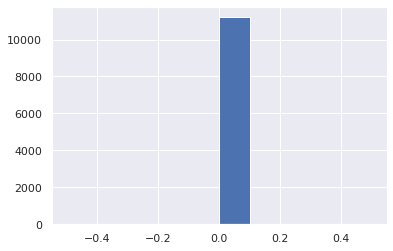

In [29]:
plt.hist(serial['broke'])


In [30]:
df_serial = pd.DataFrame(serial)

Text(0, 0.5, '# trials')

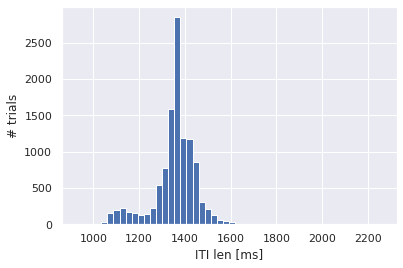

In [31]:
plt.hist(df_serial['ITI'], bins=50)
plt.xlabel('ITI len [ms]')
plt.ylabel('# trials')
#plt.savefig('../Figures/Behavioral/ITI_len_correctTrials.png', dpi=150)

In [32]:
np.mean(df_serial.loc[df_serial['monkey']=='Sa']['ITI'])

1387.570977917981

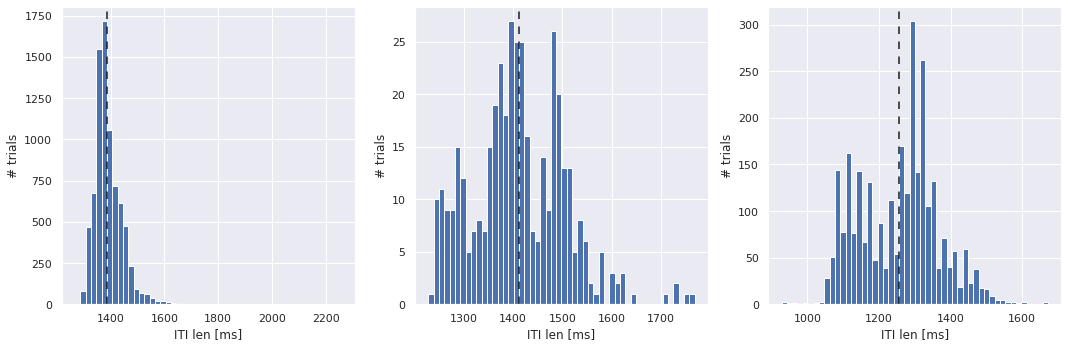

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.hist(df_serial.loc[df_serial['monkey']=='Sa']['ITI'], bins=50)
plt.axvline(np.mean(df_serial.loc[df_serial['monkey']=='Sa']['ITI']), color='k', dashes=[5,5])
plt.xlabel('ITI len [ms]')
plt.ylabel('# trials')
plt.subplot(132)
plt.hist(df_serial.loc[df_serial['monkey']=='Pe']['ITI'], bins=50)
plt.axvline(np.mean(df_serial.loc[df_serial['monkey']=='Pe']['ITI']), color='k', dashes=[5,5])
plt.xlabel('ITI len [ms]')
plt.ylabel('# trials')
plt.subplot(133)
plt.hist(df_serial.loc[df_serial['monkey']=='Wa']['ITI'], bins=50)
plt.axvline(np.mean(df_serial.loc[df_serial['monkey']=='Wa']['ITI']), color='k', dashes=[5,5])
plt.xlabel('ITI len [ms]')
plt.ylabel('# trials')
plt.tight_layout()
#plt.savefig('../Figures/Behavioral/ITI/ITIlens_allMonkeys.png', dpi=150)
plt.show()

#### Fit DoG curves

In [34]:
from scipy.optimize import curve_fit 

### Define curves to fit
# use DoG
def test_func(x,a,w):
    return a * w * x * (np.sqrt(2)/np.exp(-0.5)) * np.exp(-(w*x)**2)

# Clifford model
def test_func2(x,s,c):
    return np.sin(x)/(np.sqrt((s*np.cos(x)-c)**2+np.sin(x)**2))


x_data = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data = {'Sa':[], 'Pe':[], 'Wa':[]}
_ = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
params = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    # extract data for each monkey
    x_data[m] = sb['rel_loc'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data[m] = sb['err'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#
    x_data_onesided[m] = sb_onesided['rel_loc'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_onesided[m] = sb_onesided['err'][np.where(df_sb['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#

    # fit params for DoG
    params[m], param_cov[m] = curve_fit(test_func, x_data[m], y_data[m], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided[m], param_onesided_cov[m] = curve_fit(test_func, x_data_onesided[m], y_data_onesided[m], p0=[5, 0.015])


#### Plot serial bias

7925
411
2870


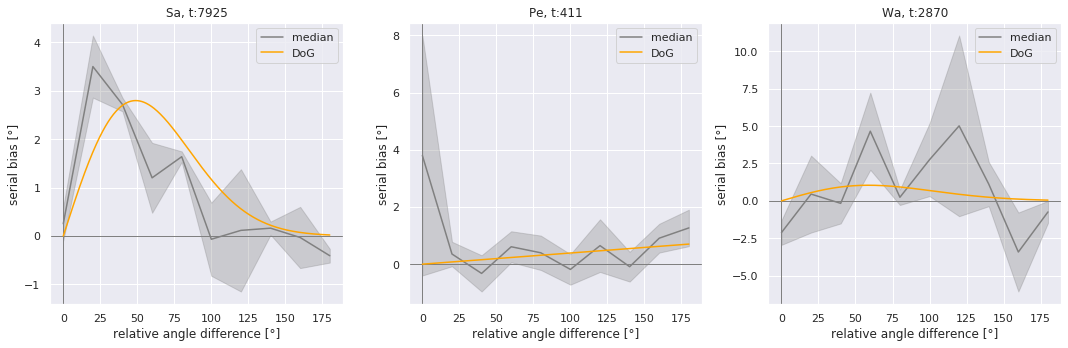

In [35]:
# plot serial bias curve, both sides
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)


plt.figure(figsize=(15,5))
for i,m in enumerate(['Sa','Pe','Wa']):#
    num_pos = len(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    x_full = np.linspace(-180,180,num_pos)
    x_full_onesided = np.linspace(0,180,int(num_pos/2+1))
    
#    plt.figure(figsize=(10,5))
#    plt.axhline(color='grey', linewidth=1)
#    plt.axvline(color='grey', linewidth=1)
#    plt.scatter(x_data[m], y_data[m], label='data', alpha=0.2)
#    # plots median of the values in each position
#    plt.fill_between(x_full,df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err']+df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').sem()['err'], df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err']-df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
#    plt.plot(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
#    # DoG fit of data
#    plt.plot(x_new, test_func(x_new, params[m][0], params[m][1]), label='DoG',color='orange')
#    # Clifford fit
#    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
#    plt.xlabel('relative angle difference [°]')
#    plt.ylabel('serial bias [°]')
#    plt.title(m)
#    plt.legend()
#    #plt.savefig('../Figures/serialBias_full_Sa0.png', dpi=150)
#    plt.show()
#    print(params)#, params2)
    print(len(df_sb.loc[df_sb['monkey']==m]))
    # plot serial bias curve, single sided
    #plt.figure()
    plt.subplot(1,3,i+1)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(x_data_onesided[m], y_data_onesided[m], alpha=0.2, label='data')
    # plots median of the values in each position
    plt.fill_between(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').mean()['err']+\
                     df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'],\
                     df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').mean()['err']-\
                     df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').mean()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided[m][0], params_onesided[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.legend()
    plt.title(m+', t:'+str(len(x_data_onesided[m])))
    
plt.tight_layout()
#plt.savefig('../Figures/Behavioral/serialBias_oneSided_allmonkeys0403.png', dpi=150)
plt.show()
#    print(params_onesided)#, params2_onesided)
#    print('Amount of data: '+str(len(x_data_onesided[m])))



#### seperated for each session

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


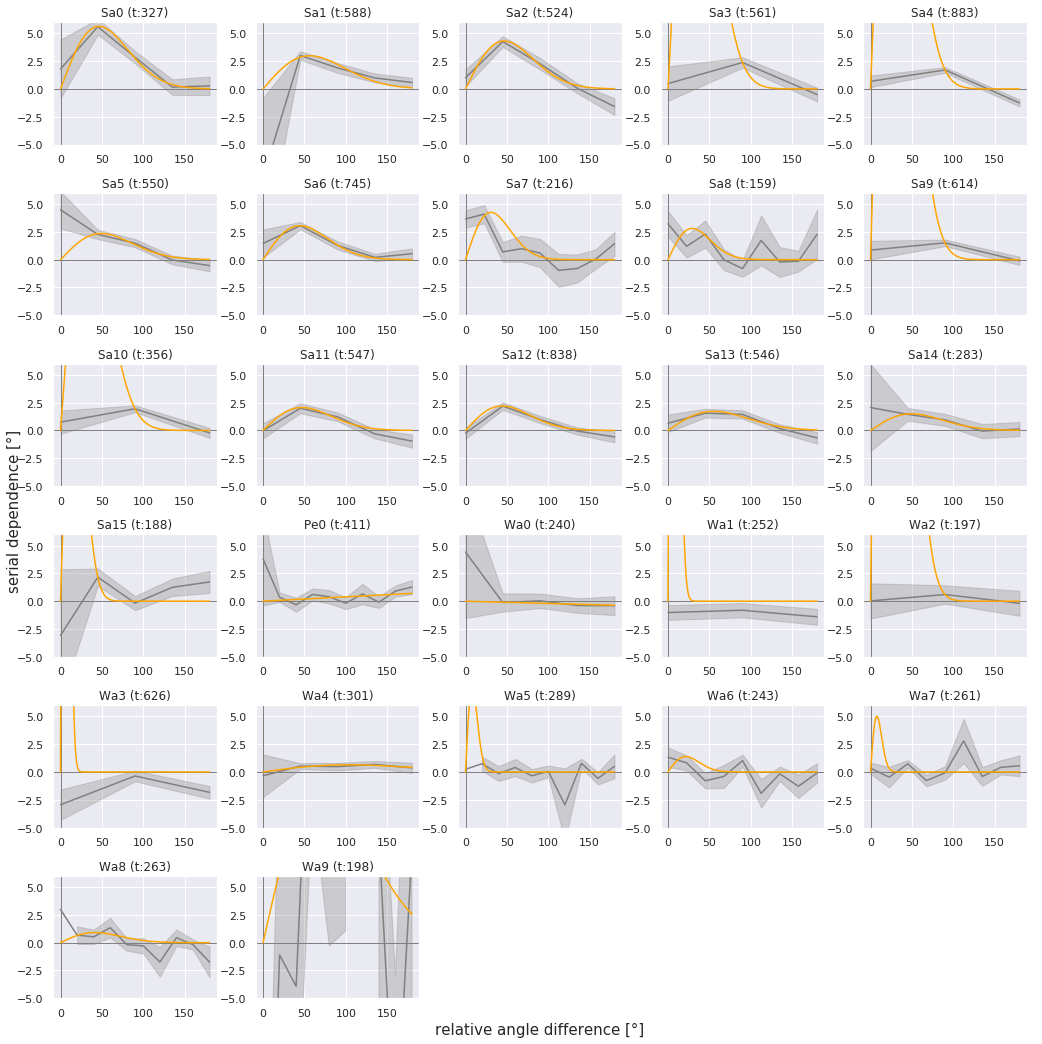

In [37]:
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)

helper=1
fig=plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.4)
for i,m in enumerate(['Sa','Pe','Wa']):#
    for n in range(max(df_dat_corr.loc[df_dat_corr['monkey']==m]['session'].values)+1):# for each session
        # fit params for DoG
        x_data_onesided = sb_onesided['rel_loc'][np.where((df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided = sb_onesided['err'][np.where((df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        par, par_cov = curve_fit(test_func, x_data_onesided, y_data_onesided, p0=[5, 0.015])


        num_pos = len(df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc')) # number of x-positions in SB curve
        x_full_onesided = np.linspace(0,180,num_pos)

        #print(len(df_sb.loc[(df_sb['monkey']==m) & (df_sb['session']==n)]))
        # plot serial bias curve, single sided
        plt.subplot(6,5,helper)
        plt.axhline(color='grey', linewidth=1)
        plt.axvline(color='grey', linewidth=1)
        # plots median of the values in each position
        plt.fill_between(x_full_onesided,df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc').mean()['err']+\
                         df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc').sem()['err'],\
                         df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc').mean()['err']-\
                         df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
        plt.plot(x_full_onesided,df_sb_onesided.loc[(df_sb_onesided['monkey']==m) & (df_sb_onesided['session']==n)].groupby('rel_loc').mean()['err'], color='grey', label='median')
        # DoG fit of data
        plt.plot(x_new_onesided, test_func(x_new_onesided, par[0], par[1]), label='DoG',color='orange')
        #plt.xlabel('relative angle difference [°]')
        #plt.ylabel('serial bias [°]')
        plt.ylim(-5,6)
        plt.title(str(m)+str(n)+' (t:'+str(len(df_sb.loc[(df_sb['monkey']==m) & (df_sb['session']==n)]))+')')
        helper=helper+1
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('relative angle difference [°]', fontsize=15)
plt.ylabel('serial dependence [°]', fontsize=15)
plt.grid(b=None)
plt.tight_layout()
#plt.savefig('../Figures/Behavioral/serialBias_oneSided_allMonkeysSessions.png', dpi=300)
plt.show()

### Serial bias into PAST

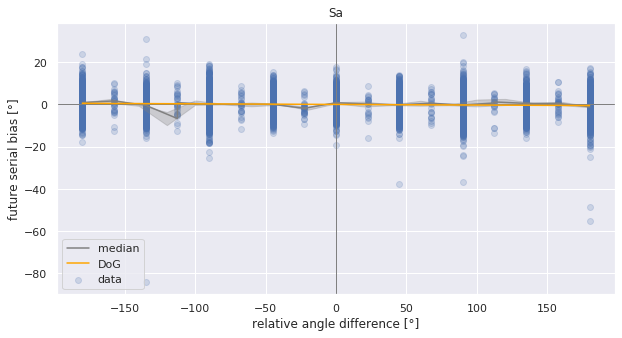

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}


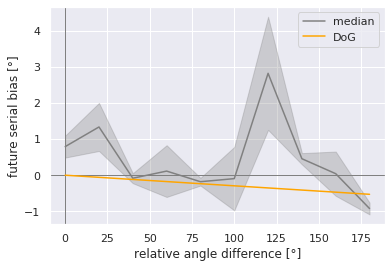

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}
Amount of data: 7925


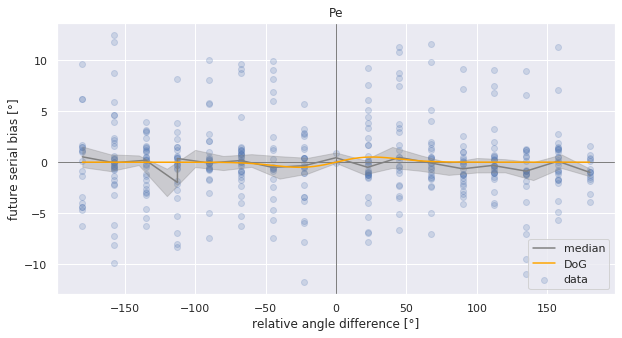

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}


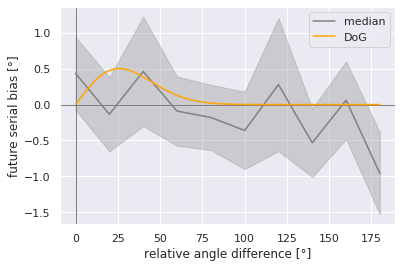

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}
Amount of data: 411


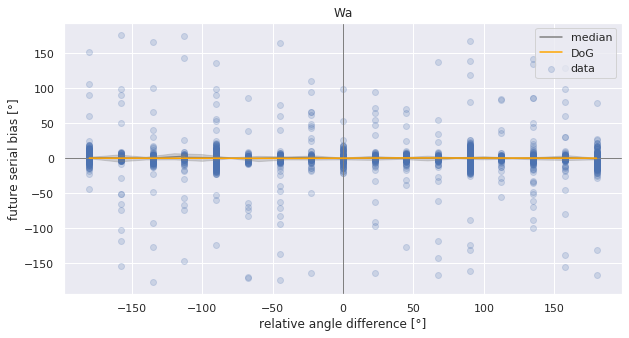

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}


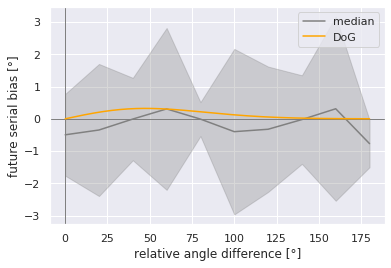

{'Sa': array([-1.79027945e+01,  7.03208329e-05]), 'Pe': array([0.50190539, 0.02745549]), 'Wa': array([0.32204344, 0.01486341])}
Amount of data: 2870


In [38]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row)
serial_past = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [],\
               'response_curr': [], 'delay_curr': [], 'monkey':[], 'session':[], 'ITI':[], 'broke':[]}

cut_off_time=5
for idx in df_dat_corr_reset.index[:-1]:# run through all correct trials (0,len)
    if df_dat_corr_reset.loc[idx,'trial_id'] < df_dat_corr_reset.loc[idx+1,'trial_id']: # only compare within one sesssion
        if np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['trial_end'])<cut_off_time: # only use trials with less than cut_off ms between 2 correct trials
            #print(df_dat.loc[df_dat_corr_reset.loc[idx,'index'], 'outcome'], df_dat.loc[df_dat_corr_reset.loc[idx+1,'index'], 'outcome'])
            serial_past['trial_id'].append(idx)
            serial_past['target_prev'].append(round(df_dat_corr_reset['targ_angle'][idx+1]*np.pi/180, 5))
            serial_past['response_prev'].append(round(df_dat_corr_reset['saccade_angle'][idx+1]*np.pi/180, 5))
            serial_past['delay_prev'].append(df_dat_corr_reset['go_cue'][idx+1]-df_dat_corr_reset['targ_off'][idx+1])
            serial_past['target_curr'].append(round(df_dat_corr_reset['targ_angle'][idx]*np.pi/180, 5))
            serial_past['response_curr'].append(round(df_dat_corr_reset['saccade_angle'][idx]*np.pi/180, 5))
            serial_past['delay_curr'].append(df_dat_corr_reset['go_cue'][idx]-df_dat_corr_reset['targ_off'][idx]) 
            serial_past['ITI'].append((df_dat_corr_reset['trial_end'][idx]-df_dat_corr_reset['go_cue'][idx])+np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['reward']) + (df_dat_corr_reset['targ_on'][idx+1]-df_dat_corr_reset['start'][idx+1]))# ITI time is time after reward + broken off fixations
            serial_past['broke'].append(df_dat_corr_reset.loc[idx+1,'index']- (df_dat_corr_reset.loc[idx,'index']+1))# how many broken trials btwn 2 correct trials
            serial_past['monkey'].append(df_dat_corr_reset['monkey'][idx])
            serial_past['session'].append(df_dat_corr_reset['session'][idx])
            
rel_loc_past, err_past = calc_errorcurve(serial_past)

sb_past = {'rel_loc': rel_loc_past*180/np.pi, 'err': err_past*180/np.pi, 'delay_prev': serial_past['delay_prev'], 'delay_curr': serial_past['delay_curr'],\
           'monkey': serial_past['monkey'], 'ITI': serial_past['ITI']}
df_sb_past = pd.DataFrame(sb_past)

sb_onesided_past = {'rel_loc': rel_loc_past*180/np.pi*np.sign(rel_loc_past),\
                    'err': np.array([err_past[i]*180/np.pi*np.sign(rel_loc_past[i]) if rel_loc_past[i] !=0 else err_past[i]*180/np.pi for i in range(len(rel_loc_past))]),\
                    'delay_prev': serial_past['delay_prev'], 'delay_curr': serial_past['delay_curr'], 'monkey': serial_past['monkey'], 'ITI': serial_past['ITI']}
df_sb_onesided_past = pd.DataFrame(sb_onesided_past)


################################ FIT DoG

x_data_past = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_past = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
params_past = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_past = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_past = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_past = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    # extract data for each monkey
    x_data_past[m] = sb_past['rel_loc'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_past[m] = sb_past['err'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#
    x_data_onesided_past[m] = sb_onesided_past['rel_loc'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
    y_data_onesided_past[m] = sb_onesided_past['err'][np.where(df_sb_past['monkey']==m)[0]]#df_sb.sort_values('rel_loc')['err']#

    # fit params for DoG
    params_past[m], param_cov_past[m] = curve_fit(test_func, x_data_past[m], y_data_past[m], p0=[5, 0.015])#p0 = [amplitude, width] 
    params_onesided_past[m], param_onesided_cov_past[m] = curve_fit(test_func, x_data_onesided_past[m], y_data_onesided_past[m], p0=[5, 0.015])


# plot serial bias curve

for m in ['Sa','Pe','Wa']:#
    num_pos_past = len(df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    x_full_past = np.linspace(-180,180,num_pos_past)
    x_full_onesided_past = np.linspace(0,180,int(num_pos_past/2+1))
    
    plt.figure(figsize=(10,5))
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(x_data_past[m], y_data_past[m], label='data', alpha=0.2)
    # plots median of the values in each position
    plt.fill_between(x_full_past,df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err']+df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err']-df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_past.loc[df_sb_past['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_past[m][0], params_past[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('future serial bias [°]')
    plt.title(m)
    plt.legend()
    #plt.savefig('../Figures/serialBiasFuture_full_Sa0.png', dpi=150)
    plt.show()
    print(params_past)#, params2)

    # plot serial bias curve, single sided
    plt.figure()
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    # plt.scatter(x_data_onesided, y_data_onesided, label='data')
    # plots median of the values in each position
    plt.fill_between(x_full_onesided_past,df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(x_full_onesided_past,df_sb_onesided_past.loc[df_sb_onesided_past['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_past[m][0], params_onesided_past[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('future serial bias [°]')
    #plt.savefig('../Figures/serialBiasFuture_oneSided_Sa0.png', dpi=150)
    plt.legend()
    plt.show()
    print(params_onesided_past)#, params2_onesided)
    print('Amount of data: '+str(len(x_data_onesided_past[m])))





#### Serial bias dependence on delay length

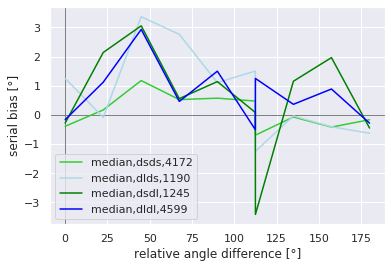

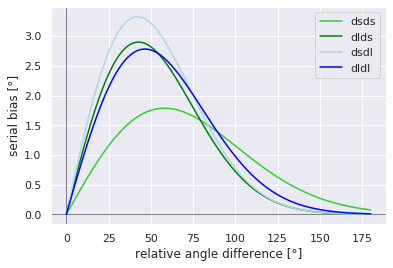

In [40]:
med = np.mean(df_sb_onesided['delay_prev'])
med2 = np.mean(df_sb_onesided['delay_curr'])
x_data_dsds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']<med2)]['rel_loc']
y_data_dsds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']<med2)]['err']
x_data_dlds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']<med2)]['rel_loc']
y_data_dlds = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']<med2)]['err']
x_data_dsdl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']>med2)]['rel_loc']
y_data_dsdl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']>med2)]['err']
x_data_dldl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']>med2)]['rel_loc']
y_data_dldl = df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']>med2)]['err']

params_dsds, param_cov_dsds = curve_fit(test_func, x_data_dsds, y_data_dsds, p0=[3, 0.015])
params_dlds, param_cov_dlds = curve_fit(test_func, x_data_dlds, y_data_dlds, p0=[3, 0.015])
params_dsdl, param_cov_dsdl = curve_fit(test_func, x_data_dsdl, y_data_dsdl, p0=[3, 0.015])
params_dldl, param_cov_dldl = curve_fit(test_func, x_data_dldl, y_data_dldl, p0=[3, 0.015])

# plot serial bias curve, single sided
plt.figure()
#plt.scatter(x_data_dlds, y_data_dlds, alpha=0.1, color='red', label='data ds')
#plt.scatter(x_data_dldl, y_data_dldl, alpha=0.1, color='blue', label='data dl')
#plt.subplot(2,1,1)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='limegreen', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']<med2)].groupby('rel_loc').median()['err'], color='limegreen', label='median,dsds,'+str(len(x_data_dsds)))
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='lightblue', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']<med2)].groupby('rel_loc').median()['err'], color='lightblue', label='median,dlds,'+str(len(x_data_dlds)))
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']<2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='green', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']<med)&(df_sb_onesided['delay_curr']>med2)].groupby('rel_loc').median()['err'], color='green', label='median,dsdl,'+str(len(x_data_dsdl)))
#plt.fill_between(x_full_onesided, df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided.loc[(df_sb_onesided['delay_prev']>2250)&(df_sb_onesided['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='blue', alpha=0.3)
plt.plot(df_sb_onesided.loc[(df_sb_onesided['delay_prev']>med)&(df_sb_onesided['delay_curr']>med2)].groupby('rel_loc').median()['err'], color='blue', label='median,dldl,'+str(len(x_data_dldl)))
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()

# DoG fit of data
plt.figure()
#plt.subplot(2,1,2)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds[0], params_dsds[1]), label='dsds',color='limegreen')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds[0], params_dlds[1]), label='dlds',color='green')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl[0], params_dsdl[1]), label='dsdl',color='lightblue')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl[0], params_dldl[1]), label='dldl',color='blue')
# Clifford fit
# plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')

#plt.subplot(3,1,3)
#plt.axhline(color='grey', linewidth=1)
#plt.axvline(color='grey', linewidth=1)
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds[0], params_dsds[1]), label='dsds',color='limegreen')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds[0], params_dlds[1]), label='dlds',color='green')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl[0], params_dsdl[1]), label='dsdl',color='lightblue')
#plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl[0], params_dldl[1]), label='dldl',color='blue')
## Clifford fit
## plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
#plt.xlabel('relative angle difference [°]')
#plt.ylabel('serial bias [°]')
#plt.ylim([0,4])

plt.legend()
plt.show()


### in past

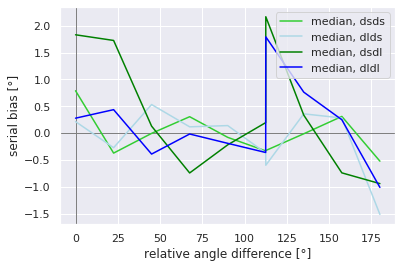

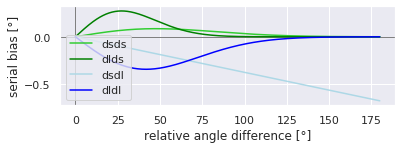

In [41]:
x_data_dsds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']<med2)]['rel_loc']
y_data_dsds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']<med2)]['err']
x_data_dlds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']<med2)]['rel_loc']
y_data_dlds_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']<med2)]['err']
x_data_dsdl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']>med2)]['rel_loc']
y_data_dsdl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']>med2)]['err']
x_data_dldl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']>med2)]['rel_loc']
y_data_dldl_past = df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']>med2)]['err']

params_dsds_past, param_cov_dsds_past = curve_fit(test_func, x_data_dsds_past, y_data_dsds_past, p0=[3, 0.015])
params_dlds_past, param_cov_dlds_past = curve_fit(test_func, x_data_dlds_past, y_data_dlds_past, p0=[3, 0.015])
params_dsdl_past, param_cov_dsdl_past = curve_fit(test_func, x_data_dsdl_past, y_data_dsdl_past, p0=[3, 0.015])
params_dldl_past, param_cov_dldl_past = curve_fit(test_func, x_data_dldl_past, y_data_dldl_past, p0=[3, 0.015])

# plot serial bias curve, single sided
plt.figure()

#plt.subplot(2,1,1)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']<med2)].groupby('rel_loc').median()['err'], color='limegreen', label='median, dsds')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='limegreen', alpha=0.3, label='median, dsds')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']<med2)].groupby('rel_loc').median()['err'], color='lightblue', label='median, dlds')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']<2250)].groupby('rel_loc').sem()['err'], color='lightblue', alpha=0.3, label='median, dlds')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<med)&(df_sb_onesided_past['delay_curr']>med2)].groupby('rel_loc').median()['err'], color='green', label='median, dsdl')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']<2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='green', alpha=0.3, label='median, dsdl')
plt.plot(df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>med)&(df_sb_onesided_past['delay_curr']>med2)].groupby('rel_loc').median()['err'], color='blue', label='median, dldl')
#plt.fill_between(x_full_onesided, df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err']- df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').median()['err'] + df_sb_onesided_past.loc[(df_sb_onesided_past['delay_prev']>2250)&(df_sb_onesided_past['delay_curr']>2250)].groupby('rel_loc').sem()['err'], color='blue', alpha=0.3, label='median, dldl')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()

plt.figure()
plt.subplot(2,1,2)
plt.axhline(color='grey', linewidth=1)
plt.axvline(color='grey', linewidth=1)
#plt.scatter(x_data_dsdl, y_data_dsdl, alpha=0.1, color='red', label='data dsdl')
#plt.scatter(x_data_dsds, y_data_dsds, alpha=0.1, color='blue', label='data dl')
## DoG fit of data
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsds_past[0], params_dsds_past[1]), label='dsds',color='limegreen')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dlds_past[0], params_dlds_past[1]), label='dlds',color='green')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dsdl_past[0], params_dsdl_past[1]), label='dsdl',color='lightblue')
plt.plot(x_new_onesided, test_func(x_new_onesided, params_dldl_past[0], params_dldl_past[1]), label='dldl',color='blue')
# Clifford fit
# plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
plt.xlabel('relative angle difference [°]')
plt.ylabel('serial bias [°]')
plt.legend()
plt.show()



-> doesn't seem like cohesive dependence on future

-> find other fit

### Error size based on ITI len

In [42]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    print('Monkey '+str(m)+': '+str(spearmanr(df_sb.loc[(df_sb['monkey']==m)]['ITI'].values, abs(df_sb.loc[(df_sb['monkey']==m)]['err'].values))))
        

Monkey Sa: SpearmanrResult(correlation=0.03295455164011556, pvalue=0.0033459225019661855)
Monkey Pe: SpearmanrResult(correlation=-0.055179103879843344, pvalue=0.2643806591656243)
Monkey Wa: SpearmanrResult(correlation=-0.13633677223214705, pvalue=2.2176041446322114e-13)


In [43]:
for i,m in enumerate(['Sa', 'Pe', 'Wa']):
    for n in range(max(df_sb.loc[df_sb['monkey']==m]['session'].values)+1):
        print('Monkey '+str(m)+str(n)+': '+str(spearmanr(df_sb.loc[(df_sb['monkey']==m) & (df_sb['session']==n)]['ITI'].values, abs(df_sb.loc[(df_sb['monkey']==m) & (df_sb['session']==n)]['err'].values))))
        

Monkey Sa0: SpearmanrResult(correlation=-0.02341238356711654, pvalue=0.6731666058681164)
Monkey Sa1: SpearmanrResult(correlation=-0.021991396605878986, pvalue=0.5945925780394128)
Monkey Sa2: SpearmanrResult(correlation=0.02269953469527925, pvalue=0.6041499178621448)
Monkey Sa3: SpearmanrResult(correlation=0.045178217162296794, pvalue=0.2854191910858961)
Monkey Sa4: SpearmanrResult(correlation=0.015066543583961065, pvalue=0.6548041014343859)
Monkey Sa5: SpearmanrResult(correlation=0.0034281145138953446, pvalue=0.9360672648896315)
Monkey Sa6: SpearmanrResult(correlation=0.03380323884388694, pvalue=0.35686098367325336)
Monkey Sa7: SpearmanrResult(correlation=-0.01219758086673862, pvalue=0.8585395802121494)
Monkey Sa8: SpearmanrResult(correlation=-0.07152337699558287, pvalue=0.3703021450185463)
Monkey Sa9: SpearmanrResult(correlation=0.020906205647735075, pvalue=0.6051308559710475)
Monkey Sa10: SpearmanrResult(correlation=0.01294146643060823, pvalue=0.8077493537447884)
Monkey Sa11: Spearma

# Serial dependence based on hemifields

In [44]:
# create list with values needed for serial bias calculation (ONLY if two trials are in a row, ONLY if in SAME/OPPOSING hemifields)
# no need to extra specify sessions, trial_id changes from large # to small #
serial_sameH = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [],\
                'response_curr': [], 'delay_curr': [], 'ITI':[], 'monkey': [], 'session':[]}
serial_oppH = {'trial_id':[], 'target_prev': [], 'response_prev': [], 'delay_prev': [], 'target_curr': [],\
               'response_curr': [], 'delay_curr': [], 'ITI':[], 'monkey': [], 'session':[]}
for idx in df_dat_corr_reset.index[:-1]:# run through all correct trials (0,len)
    if df_dat_corr_reset.loc[idx,'trial_id'] < df_dat_corr_reset.loc[idx+1,'trial_id']: # only compare within one sesssion
        if np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['trial_end'])<cut_off_time: # only use trials with less than cut_off ms between 2 correct trials
            # if trials in same hemifield
            if (df_dat_corr_reset['hemifield'][idx] == df_dat_corr_reset['hemifield'][idx+1]):
                serial_sameH['trial_id'].append(df_dat_corr_reset.loc[idx,'index'])
                serial_sameH['target_prev'].append(round(df_dat_corr_reset['targ_angle'][idx]*np.pi/180, 5))
                serial_sameH['response_prev'].append(round(df_dat_corr_reset['saccade_angle'][idx]*np.pi/180, 5))
                serial_sameH['delay_prev'].append(df_dat_corr_reset['go_cue'][idx]-df_dat_corr_reset['targ_off'][idx])
                serial_sameH['target_curr'].append(round(df_dat_corr_reset['targ_angle'][idx+1]*np.pi/180, 5))
                serial_sameH['response_curr'].append(round(df_dat_corr_reset['saccade_angle'][idx+1]*np.pi/180, 5))
                serial_sameH['delay_curr'].append(df_dat_corr_reset['go_cue'][idx+1]-df_dat_corr_reset['targ_off'][idx+1]) 
                serial_sameH['ITI'].append((df_dat_corr_reset['trial_end'][idx]-df_dat_corr_reset['reward'][idx])+np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['reward']))
                serial_sameH['monkey'].append(df_dat_corr_reset['monkey'][idx])
                serial_sameH['session'].append(df_dat_corr_reset['session'][idx])
            # if trials in opposite hemifield
            else:
                serial_oppH['trial_id'].append(df_dat_corr_reset.loc[idx,'index'])
                serial_oppH['target_prev'].append(round(df_dat_corr_reset['targ_angle'][idx]*np.pi/180, 5))
                serial_oppH['response_prev'].append(round(df_dat_corr_reset['saccade_angle'][idx]*np.pi/180, 5))
                serial_oppH['delay_prev'].append(df_dat_corr_reset['go_cue'][idx]-df_dat_corr_reset['targ_off'][idx])
                serial_oppH['target_curr'].append(round(df_dat_corr_reset['targ_angle'][idx+1]*np.pi/180, 5))
                serial_oppH['response_curr'].append(round(df_dat_corr_reset['saccade_angle'][idx+1]*np.pi/180, 5))
                serial_oppH['delay_curr'].append(df_dat_corr_reset['go_cue'][idx+1]-df_dat_corr_reset['targ_off'][idx+1]) 
                serial_oppH['ITI'].append((df_dat_corr_reset['trial_end'][idx]-df_dat_corr_reset['reward'][idx])+np.sum(df_dat[df_dat_corr_reset.loc[idx,'index']+1:df_dat_corr_reset.loc[idx+1,'index']]['reward']))
                serial_oppH['monkey'].append(df_dat_corr_reset['monkey'][idx])
                serial_oppH['session'].append(df_dat_corr_reset['session'][idx])

rel_loc_sameH, err_sameH = calc_errorcurve(serial_sameH)
rel_loc_oppH, err_oppH = calc_errorcurve(serial_oppH)

sb_sameH = {'rel_loc': rel_loc_sameH*180/np.pi, 'err': err_sameH*180/np.pi, 'delay_prev': serial_sameH['delay_prev'],\
            'delay_curr': serial_sameH['delay_curr'], 'target_prev':np.round(np.array(serial_sameH['target_prev'])*180/np.pi,1),\
            'target_curr':np.round(np.array(serial_sameH['target_curr'])*180/np.pi,1),\
            'ITI': serial_sameH['ITI'], 'monkey': serial_sameH['monkey'], 'session': serial_sameH['session']}
df_sb_sameH = pd.DataFrame(sb_sameH)
sb_onesided_sameH = {'rel_loc': rel_loc_sameH*180/np.pi*np.sign(rel_loc_sameH),\
                     'err': np.array([err_sameH[i]*180/np.pi*np.sign(rel_loc_sameH[i]) if rel_loc_sameH[i] !=0 else err_sameH[i]*180/np.pi for i in range(len(rel_loc_sameH))]),\
                     'delay_prev': serial_sameH['delay_prev'], 'delay_curr': serial_sameH['delay_curr'],\
                     'target_prev':np.round(np.array(serial_sameH['target_prev'])*180/np.pi,1),\
                     'target_curr':np.round(np.array(serial_sameH['target_curr'])*180/np.pi,1),\
                     'ITI': serial_sameH['ITI'], 'monkey': serial_sameH['monkey'], 'session': serial_sameH['session']}
df_sb_onesided_sameH = pd.DataFrame(sb_onesided_sameH)

sb_oppH = {'rel_loc': rel_loc_oppH*180/np.pi, 'err': err_oppH*180/np.pi, 'delay_prev': serial_oppH['delay_prev'],\
           'delay_curr': serial_oppH['delay_curr'], 'target_prev':np.round(np.array(serial_oppH['target_prev'])*180/np.pi, 1),\
           'target_curr':np.round(np.array(serial_oppH['target_curr'])*180/np.pi, 1),\
           'ITI': serial_oppH['ITI'], 'monkey': serial_oppH['monkey'], 'session': serial_oppH['session']}
df_sb_oppH = pd.DataFrame(sb_oppH)
sb_onesided_oppH = {'rel_loc': rel_loc_oppH*180/np.pi*np.sign(rel_loc_oppH),\
                    'err': np.array([err_oppH[i]*180/np.pi*np.sign(rel_loc_oppH[i]) if rel_loc_oppH[i] !=0 else err_oppH[i]*180/np.pi for i in range(len(rel_loc_oppH))]),\
                    'delay_prev': serial_oppH['delay_prev'], 'delay_curr': serial_oppH['delay_curr'],\
                    'target_prev':np.round(np.array(serial_oppH['target_prev'])*180/np.pi, 1),\
                    'target_curr':np.round(np.array(serial_oppH['target_curr'])*180/np.pi, 1),\
                    'ITI': serial_oppH['ITI'], 'monkey': serial_oppH['monkey'], 'session': serial_oppH['session']}
df_sb_onesided_oppH = pd.DataFrame(sb_onesided_oppH)



### DoG fit

In [45]:
x_data_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_sameH = {'Sa':[], 'Pe':[], 'Wa':[]}

x_data_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
x_data_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
y_data_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_cov_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
params_onesided_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
param_onesided_cov_oppH = {'Sa':[], 'Pe':[], 'Wa':[]}
# fit curve for every monkey
for m in ['Sa','Pe','Wa']:
    for n in range(len(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby(['session']).groups.keys())): #for each session per monkey
        # extract data for each monkey
        x_data_sameH[m] = sb_sameH['rel_loc'][np.where((df_sb_sameH['monkey']==m) & (df_sb_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_sameH[m] = sb_sameH['err'][np.where((df_sb_sameH['monkey']==m) & (df_sb_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        x_data_onesided_sameH[m] = sb_onesided_sameH['rel_loc'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_sameH[m] = sb_onesided_sameH['err'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#

        # fit params for DoG
        params_sameH[m], param_cov_sameH[m] = curve_fit(test_func, x_data_sameH[m], y_data_sameH[m], p0=[5, 0.015])#p0 = [amplitude, width] 
        params_onesided_sameH[m], param_onesided_cov_sameH[m] = curve_fit(test_func, x_data_onesided_sameH[m], y_data_onesided_sameH[m], p0=[5, 0.015])

        # OPPOSITE hemifield
        x_data_oppH[m] = sb_oppH['rel_loc'][np.where((df_sb_oppH['monkey']==m) & (df_sb_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_oppH[m] = sb_oppH['err'][np.where((df_sb_oppH['monkey']==m) & (df_sb_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        x_data_onesided_oppH[m] = sb_onesided_oppH['rel_loc'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_oppH[m] = sb_onesided_oppH['err'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#

        # fit params for DoG
        params_oppH[m], param_cov_oppH[m] = curve_fit(test_func, x_data_oppH[m], y_data_oppH[m], p0=[5, 0.015])#p0 = [amplitude, width] 
        params_onesided_oppH[m], param_onesided_cov_oppH[m] = curve_fit(test_func, x_data_onesided_oppH[m], y_data_onesided_oppH[m], p0=[5, 0.015])

        print(str(m)+str(n)+': difference err, same/opp hemifield: '+str(ttest_ind(df_sb_onesided_sameH.loc[(df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n)]['err'].values,df_sb_onesided_oppH.loc[(df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n)]['err'].values)))


Sa0: difference err, same/opp hemifield: Ttest_indResult(statistic=3.8601483246748214, pvalue=0.00013671062332013757)
Sa1: difference err, same/opp hemifield: Ttest_indResult(statistic=4.699075956151993, pvalue=3.260143664725481e-06)
Sa2: difference err, same/opp hemifield: Ttest_indResult(statistic=3.413760655631624, pvalue=0.0006905296967597308)
Sa3: difference err, same/opp hemifield: Ttest_indResult(statistic=3.433239551165053, pvalue=0.0006405875862451399)
Sa4: difference err, same/opp hemifield: Ttest_indResult(statistic=-3.425158069310102, pvalue=0.0006428274051215622)
Sa5: difference err, same/opp hemifield: Ttest_indResult(statistic=3.6397889052107244, pvalue=0.0002986972667326702)
Sa6: difference err, same/opp hemifield: Ttest_indResult(statistic=3.7802121415598346, pvalue=0.0001692629345564883)
Sa7: difference err, same/opp hemifield: Ttest_indResult(statistic=4.598895393397593, pvalue=7.265079102496472e-06)
Sa8: difference err, same/opp hemifield: Ttest_indResult(statistic=

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Wa4: difference err, same/opp hemifield: Ttest_indResult(statistic=-1.6194307547729228, pvalue=0.10640884151891242)
Wa5: difference err, same/opp hemifield: Ttest_indResult(statistic=0.9671713219944271, pvalue=0.33427269301953566)
Wa6: difference err, same/opp hemifield: Ttest_indResult(statistic=1.2273131007693017, pvalue=0.22090244041290305)
Wa7: difference err, same/opp hemifield: Ttest_indResult(statistic=0.08456515555301973, pvalue=0.9326724300262396)
Wa8: difference err, same/opp hemifield: Ttest_indResult(statistic=-0.16738168994844596, pvalue=0.867199344888911)
Wa9: difference err, same/opp hemifield: Ttest_indResult(statistic=0.1373360615282592, pvalue=0.8909061436049941)


### check distribution of trials/errors within/across hemifields

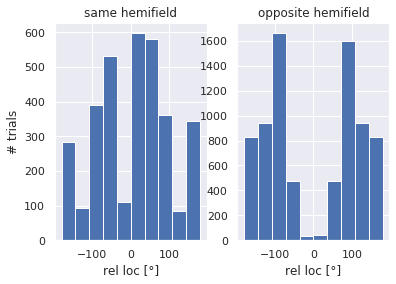

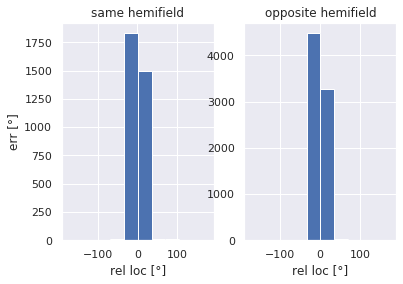

In [46]:
plt.figure()
plt.subplot(121)
plt.hist(rel_loc_sameH*180/np.pi, label='same')
plt.xlabel('rel loc [°]')
plt.ylabel('# trials')
plt.title('same hemifield')
plt.subplot(122)
plt.hist(rel_loc_oppH*180/np.pi, label='opp')
plt.title('opposite hemifield')
plt.xlabel('rel loc [°]')
plt.show()

plt.figure()
plt.subplot(121)
plt.hist(err_sameH*180/np.pi, label='same')
plt.xlabel('rel loc [°]')
plt.ylabel('err [°]')
plt.title('same hemifield')
plt.subplot(122)
plt.hist(err_oppH*180/np.pi, label='opp')
plt.title('opposite hemifield')
plt.xlabel('rel loc [°]')
plt.show()


2405
5520


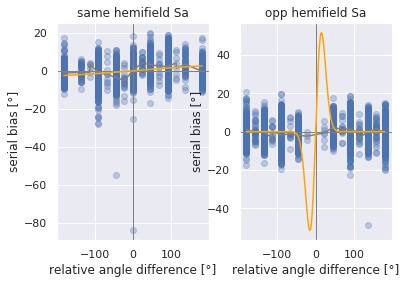

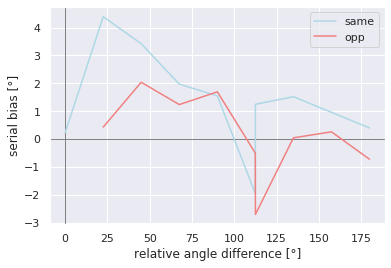

144
267


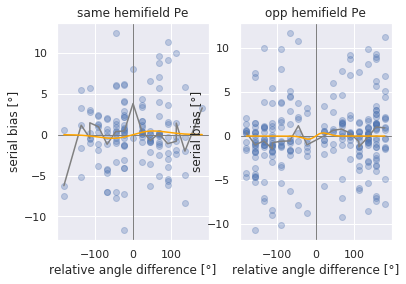

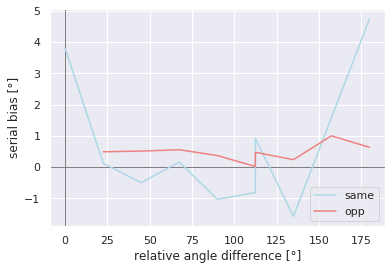

830
2040


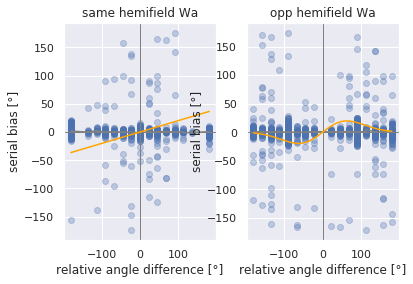

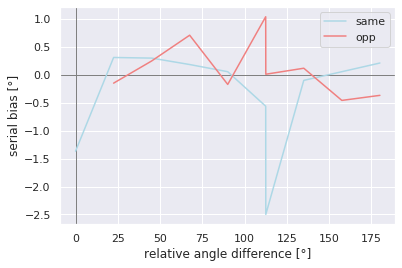

In [47]:
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)


for m in ['Sa','Pe','Wa']:
    #num_pos = len(df_sb.loc[df_sb['monkey']==m].groupby('rel_loc')) # number of x-positions in SB curve
    #x_full = np.linspace(-180,180,num_pos)
    #x_full_onesided = np.linspace(0,180,int(num_pos/2+1))
    
    print(len(df_sb_sameH.loc[df_sb_sameH['monkey']==m]['rel_loc']))
    print(len(df_sb_oppH.loc[df_sb_oppH['monkey']==m]['rel_loc']))
    plt.figure()
    plt.subplot(121)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(df_sb_sameH.loc[df_sb_sameH['monkey']==m]['rel_loc'], df_sb_sameH.loc[df_sb_sameH['monkey']==m]['err'], alpha=0.3, label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full,df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_sameH[m][0], params_sameH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.title('same hemifield '+str(m))
    
    plt.subplot(122)
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    plt.scatter(df_sb_oppH.loc[df_sb_oppH['monkey']==m]['rel_loc'], df_sb_oppH.loc[df_sb_oppH['monkey']==m]['err'], alpha=0.3, label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full,df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_oppH.loc[df_sb_oppH['monkey']==m].groupby('rel_loc').median()['err'], color='grey', label='median')
    # DoG fit of data
    plt.plot(x_new, test_func(x_new, params_oppH[m][0], params_oppH[m][1]), label='DoG',color='orange')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2[0], params2[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.title('opp hemifield '+str(m))
    #plt.legend()
    plt.show()
    #print(params)#, params2)

    
    
    # plot serial bias curve, single sided
    plt.figure()
    plt.axhline(color='grey', linewidth=1)
    plt.axvline(color='grey', linewidth=1)
    #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided_sameH.loc[df_sb_onesided_sameH['monkey']==m].groupby('rel_loc').median()['err'], color='lightblue', label='same')
    # DoG fit of data
    #plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_sameH[m][0], params_onesided_sameH[m][1]), color='darkblue')

    #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
    # plots median of the values in each position
    #plt.fill_between(x_full_onesided,df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
    plt.plot(df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err'], color='lightcoral', label='opp')
    # DoG fit of data
    #plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_oppH[m][0], params_onesided_oppH[m][1]),color='darkred')
    # Clifford fit
    # plt.plot(x_new, test_func2(x_new, params2_onesided[0], params2_onesided[1]), label='Clifford',color='cyan')
    plt.xlabel('relative angle difference [°]')
    plt.ylabel('serial bias [°]')
    plt.legend()
    plt.show()
    #print(params_onesided)#, params2_onesided)
    #print('Amount of data: '+str(len(x_data_onesided[m])))

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


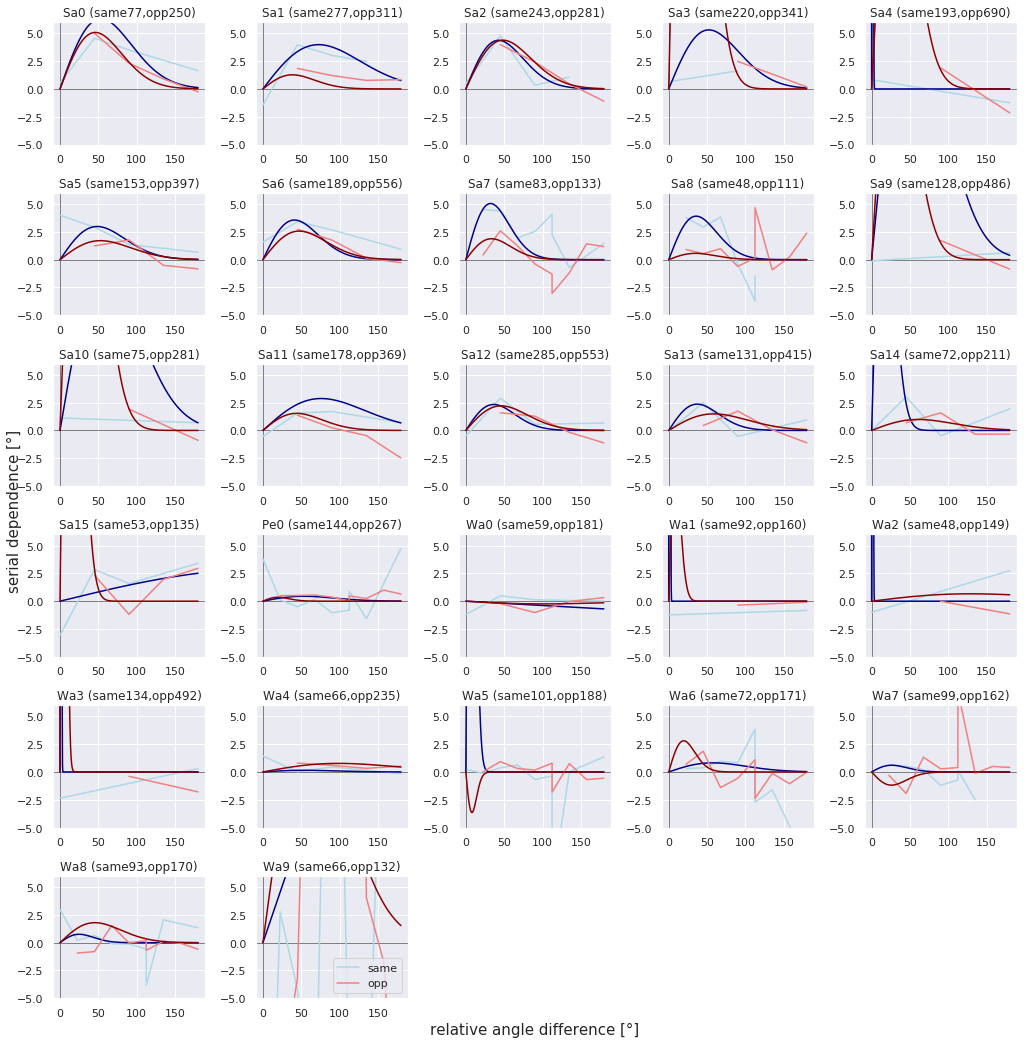

In [49]:
x_new = np.linspace(-180, 180, 1000)
x_new_onesided = np.linspace(0, 180, 500)

helper=1
fig=plt.figure(figsize=(15,15))
for m in ['Sa','Pe','Wa']:
    for n in range(len(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby(['session']).groups.keys())): #for each session per monkey
    
        x_data_onesided_sameH = sb_onesided_sameH['rel_loc'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_sameH = sb_onesided_sameH['err'][np.where((df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        params_onesided_sameH, param_onesided_cov_sameH = curve_fit(test_func, x_data_onesided_sameH, y_data_onesided_sameH, p0=[5, 0.015])
        # OPPOSITE hemifield
        x_data_onesided_oppH = sb_onesided_oppH['rel_loc'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['rel_loc']#sb['rel_loc']
        y_data_onesided_oppH = sb_onesided_oppH['err'][np.where((df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n))[0]]#df_sb.sort_values('rel_loc')['err']#
        params_onesided_oppH, param_onesided_cov_oppH = curve_fit(test_func, x_data_onesided_oppH, y_data_onesided_oppH, p0=[5, 0.015])

        plt.subplot(6,5,helper)
        plt.axhline(color='grey', linewidth=1)
        plt.axvline(color='grey', linewidth=1)
        #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
        # plots median of the values in each position
        #plt.fill_between(x_full_onesided,df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided.loc[df_sb_onesided['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
        plt.plot(df_sb_onesided_sameH.loc[(df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n)].groupby('rel_loc').median()['err'], color='lightblue', label='same')
        # DoG fit of data
        plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_sameH[0], params_onesided_sameH[1]),color='darkblue')
        #plt.scatter(df_sb_onesided.loc[df_sb_onesided['monkey']==m]['rel_loc'], df_sb_onesided.loc[df_sb_onesided['monkey']==m]['err'], label='data')
        # plots median of the values in each position
        #plt.fill_between(x_full_onesided,df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']+df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').median()['err']-df_sb_onesided_oppH.loc[df_sb_onesided_oppH['monkey']==m].groupby('rel_loc').sem()['err'], color='grey', alpha=0.3)
        plt.plot(df_sb_onesided_oppH.loc[(df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n)].groupby('rel_loc').median()['err'], color='lightcoral', label='opp')
        # DoG fit of data
        plt.plot(x_new_onesided, test_func(x_new_onesided, params_onesided_oppH[0], params_onesided_oppH[1]),color='darkred')
        plt.title(str(m)+str(n)+' (same'+str(len(y_data_onesided_sameH))+',opp'+str(len(y_data_onesided_oppH))+')')
        plt.ylim(-5,6)
        helper+=1
plt.legend()        
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('relative angle difference [°]', fontsize=15)
plt.ylabel('serial dependence [°]', fontsize=15)
plt.grid(b=None)
plt.tight_layout()
plt.show()


### Ttest for errors between same/opp hemifields < 90°, each monkey across sessions

In [50]:
check_bias_max=70
for m in ['Sa', 'Pe', 'Wa']:
    print(str(m)+': difference err, same/opp hemifield: '+str(ttest_ind(df_sb_onesided_sameH.loc[(df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['rel_loc']<check_bias_max)]['err'].values,df_sb_onesided_oppH.loc[(df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['rel_loc']<check_bias_max)]['err'].values)))


Sa: difference err, same/opp hemifield: Ttest_indResult(statistic=1.2052360027886213, pvalue=0.22826127214607408)
Pe: difference err, same/opp hemifield: Ttest_indResult(statistic=1.0758173801771806, pvalue=0.2836489526186596)
Wa: difference err, same/opp hemifield: Ttest_indResult(statistic=-1.1324366930399345, pvalue=0.2578024854604439)


In [51]:
check_bias_max=70
for m in ['Sa', 'Pe', 'Wa']:
    for n in range(len(df_sb_sameH.loc[df_sb_sameH['monkey']==m].groupby(['session']).groups.keys())): #for each session per monkey
        print(str(m)+str(n)+': difference err, same/opp hemifield: '+str(ttest_ind(df_sb_onesided_sameH.loc[(df_sb_onesided_sameH['monkey']==m) & (df_sb_onesided_sameH['session']==n) & (df_sb_onesided_sameH['rel_loc']<check_bias_max)]['err'].values,df_sb_onesided_oppH.loc[(df_sb_onesided_oppH['monkey']==m) & (df_sb_onesided_oppH['session']==n) & (df_sb_onesided_oppH['rel_loc']<check_bias_max)]['err'].values)))


Sa0: difference err, same/opp hemifield: Ttest_indResult(statistic=0.5046642138053691, pvalue=0.6149884075654748)
Sa1: difference err, same/opp hemifield: Ttest_indResult(statistic=0.9196851185782975, pvalue=0.35898900034125825)
Sa2: difference err, same/opp hemifield: Ttest_indResult(statistic=-0.6143080740283148, pvalue=0.5398141652591608)
Sa3: difference err, same/opp hemifield: Ttest_indResult(statistic=nan, pvalue=nan)
Sa4: difference err, same/opp hemifield: Ttest_indResult(statistic=nan, pvalue=nan)
Sa5: difference err, same/opp hemifield: Ttest_indResult(statistic=2.0223099196423133, pvalue=0.04492160900737365)
Sa6: difference err, same/opp hemifield: Ttest_indResult(statistic=1.2222109293389578, pvalue=0.22294771011031245)
Sa7: difference err, same/opp hemifield: Ttest_indResult(statistic=2.251983022822117, pvalue=0.026651230919184716)
Sa8: difference err, same/opp hemifield: Ttest_indResult(statistic=1.9973677579085622, pvalue=0.05074176784576942)
Sa9: difference err, same/op

### compute distance from y axis

In [51]:
df_sb_sameH.head()

rel_loc        err  delay_prev  delay_curr  target_prev  target_curr  \
0 -44.977187 -55.080152      2520.0      2520.0        270.0        225.0   
1 -90.011670  -0.592438      2320.0      2220.0        135.0         45.0   
2 -44.977187 -10.092652      2020.0      2120.0        315.0        270.0   
3 -44.977187  -0.544310      2520.0      2019.0         90.0         45.0   
4  44.977187   0.192514      2320.0      2020.0        270.0        315.0   

     ITI monkey  session  
0  778.0     Sa        0  
1  779.0     Sa        0  
2  777.0     Sa        0  
3  775.0     Sa        0  
4  778.0     Sa        0

In [52]:
y_dist_prev_same=[]
y_dist_curr_same= []
y_dist_prev_opp=[]
y_dist_curr_opp= []
for n in range(len(df_sb_sameH['target_prev'])):
    if df_sb_sameH['target_prev'][n]<180:
        y_dist_prev_same.append(abs(90-df_sb_sameH['target_prev'][n]))
    else:
        y_dist_prev_same.append(abs(270-df_sb_sameH['target_prev'][n]))
        
    if df_sb_sameH['target_curr'][n]<180:
        y_dist_curr_same.append(abs(90-df_sb_sameH['target_curr'][n]))
    else:
        y_dist_curr_same.append(abs(270-df_sb_sameH['target_curr'][n]))
        
for n in range(len(df_sb_oppH['target_prev'])): 
    if df_sb_oppH['target_prev'][n]<180:
        y_dist_prev_opp.append(abs(90-df_sb_oppH['target_prev'][n]))
    else:
        y_dist_prev_opp.append(abs(270-df_sb_oppH['target_prev'][n]))
        
    if df_sb_oppH['target_curr'][n]<180:
        y_dist_curr_opp.append(abs(90-df_sb_oppH['target_curr'][n]))
    else:
        y_dist_curr_opp.append(abs(270-df_sb_oppH['target_curr'][n]))
        
df_sb_sameH['y_dist_prev'] = y_dist_prev_same
df_sb_sameH['y_dist_curr'] = y_dist_curr_same
df_sb_oppH['y_dist_prev'] = y_dist_prev_opp
df_sb_oppH['y_dist_curr'] = y_dist_curr_opp

### plot error for specific relative distance between stimuli for each hemifield over y-distance

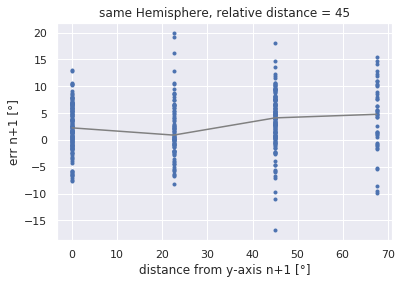

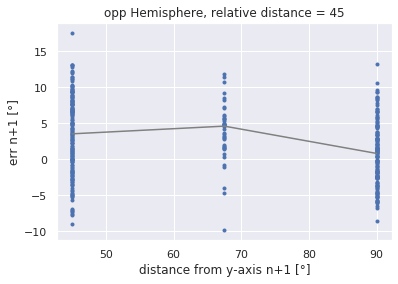

In [53]:
val = 45

plt.figure()
plt.plot(df_sb_sameH['y_dist_curr'].loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)],df_sb_sameH['err'].loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)], '.')
plt.plot(df_sb_sameH.loc[np.where(np.round(df_sb_sameH['rel_loc']) == val)].groupby(['y_dist_curr']).median()['err'], color='grey')
plt.xlabel('distance from y-axis n+1 [°]')
plt.ylabel('err n+1 [°]')
plt.title('same Hemisphere, relative distance = '+str(val))
plt.show()

plt.figure()
plt.plot(df_sb_oppH['y_dist_curr'].loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)],df_sb_oppH['err'].loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)], '.')
plt.plot(df_sb_oppH.loc[np.where(np.round(df_sb_oppH['rel_loc']) == val)].groupby(['y_dist_curr']).median()['err'], color='grey')
plt.xlabel('distance from y-axis n+1 [°]')
plt.ylabel('err n+1 [°]')
plt.title('opp Hemisphere, relative distance = '+str(val))
plt.show()
